In [17]:
import xarray as xr
import numpy as np
import glob as glob
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
import matplotlib as mpl
import colormaps
import glob as glob
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import ScalarFormatter,AutoLocator,MultipleLocator,AutoMinorLocator,FixedLocator
from matplotlib.patches import Rectangle

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.ticker import MaxNLocator

from metpy.calc import mixing_ratio_from_specific_humidity,saturation_mixing_ratio,mixing_ratio_from_specific_humidity
from metpy.units import units
from metpy.constants import Rv,Lv

# Create a custom RdYlBu colormap with white in the middle
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['hatch.color'] = 'silver'

from imods.stats import *

In [14]:
## Lapse rate

In [15]:
t = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/remapped/isotope-nudging2.cam.h0.T.197901-202212.latlon.ERA5.nc')
t

<xarray.Dataset>
Dimensions:    (plev: 37, time: 528, latitude: 73, longitude: 144, bnds: 2)
Coordinates:
  * plev       (plev) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1
  * time       (time) object 0001-02-01 00:00:00 ... 0045-01-01 00:00:00
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    PS         (time, latitude, longitude) float32 ...
    T          (time, plev, latitude, longitude) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/15)
    creation_date:    Fri Mar 29 14:32:02 PDT 2024
    source_file:      /raid/scratch/scratch-itbaxter/exp/amip-low-water-nudgi...
    title:            UNSET
    CDI:              Climate Data Interface version 2.3.0 (https://mpimet.mp...
    Conventions:      CF-1.0
    source:           CAM
    ...               ...
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.ie12.B1850C5CN.f19_g16.LME.002.cam.i.1850-01-01-00000.nc
    topography_file:  /home/scratch-qinghua3/CESM/input/atm/cam/topo/USGS-gto...
    history:          Fri Mar 29 14:26:14 2024: cdo remapcon,./grid_ERA5_2.5d...
    CDO:              Climate Data Operators version 2.3.0 (https://mpimet.mp...

In [16]:
dTA2 = preprocess(t['T'])
dTA2

/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

1


KeyboardInterrupt: 

In [ ]:
dta = xr.open_dataset('./t_trend.month.1981-2022.nc')
dta

In [ ]:
def month_loop(ds,month=1):
    print(month)
    ds_sel = mon(ds,month=month).sel(year=slice(1981,2022))
    r = linregress(ds_sel,ds_sel.year) #.slope
    return r

def preprocess(ds):
    ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
    dqs = [month_loop(ds,month=month) for month in range(1,13)]
    dqs = xr.concat(dqs,dim='month')
    dqs.coords['month'] = np.arange(1,13,step=1)
    return dqs

TS = preprocess(ts['TS'])
TS

In [ ]:
_,TS_lev = xr.broadcast(dta.slope,TS.slope)
TS_lev

In [ ]:
TS_col = area_weighted_ave(TS_lev.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
TS_col

In [ ]:
dT_col = area_weighted_ave(dta.slope.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
dT_col

In [ ]:
dT_col.plot(y='plev',yincrease=False)
TS_col.plot(y='plev',yincrease=False)

In [ ]:
_,TAS = xr.broadcast(T0['T'],tas)
TAS

In [ ]:
dTl = dqo.slope/q0['Q']*Rv.magnitude/Lv.magnitude*TAS**2
#dT.coords['plev'] = dT['plev']/100
dTl

In [ ]:
dlRq_LW=(Kq_LW['SFC_all']*(dT-TS_lev).rename({'plev':'level'})*dp/100) #.sum('level')
dlRq_SW=(Kq_SW['SFC_all']*(dT-TS_lev).rename({'plev':'level'})*dp/100) #.sum('level')
dlRq_SW

In [ ]:
fig = plt.figure(figsize=(7.5,7.5))
cmap = colormaps.BlueWhiteOrangeRed

ax = fig.add_subplot(311)
ax.set_title('WV feedback using ERA5 kernels')
for axis in ['bottom','left', 'right', 'top']:
    ax.spines[axis].set_linewidth(1.25)
ax.invert_yaxis()
ax.text(-0.05, 1.2, 'a',
        weight='bold',
        fontsize=13,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

wvf = (10*(dlRq_LW+dlRq_SW)).sel(month=slice(6,8)).mean(('month','longitude'))
p = wvf.plot(ax=ax,cmap=cmap,
             #vmin=-0.2,vmax=0.2,
             yincrease=False)
p.axes.set_title('WV feedback using TS')

cmap = colormaps.BlueWhiteOrangeRed
ax = fig.add_subplot(312)
ax.set_title('WV feedback using ERA5 kernels')
for axis in ['bottom','left', 'right', 'top']:
    ax.spines[axis].set_linewidth(1.25)
ax.invert_yaxis()
ax.text(-0.05, 1.2, 'a',
        weight='bold',
        fontsize=13,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

p = (10*(dRq_LW+dRq_SW)).sel(month=slice(6,8)).mean(('month','longitude')).plot(ax=ax,cmap=cmap,
                                                                             #vmin=-0.2,vmax=0.2,
                                                                             yincrease=False)
p.axes.set_title('WV feedback using ERA5 kernels')

ax = fig.add_subplot(313)
ax.set_title('WV feedback using TA')
for axis in ['bottom','left', 'right', 'top']:
    ax.spines[axis].set_linewidth(1.25)
ax.invert_yaxis()
ax.text(-0.05, 1.2, 'a',
        weight='bold',
        fontsize=13,
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

wvf = (10*((dlRq_LW+dlRq_SW)-(dRq_LW+dRq_SW))).sel(month=slice(6,8)).mean(('month','longitude'))
p = wvf.plot(ax=ax,cmap=cmap,
             #vmin=-0.2,vmax=0.2,
             yincrease=False)
p.axes.set_title('Difference')

plt.tight_layout()

In [ ]:
## Create new fixed relative humidity feedback
k_ts = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_TOA.nc')

dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/'

k_t = xr.open_dataset(dir+'ERA5_kernel_ta_dp_TOA.nc')
k_t

k_q_sw = xr.open_dataset(dir+'ERA5_kernel_wv_sw_dp_TOA.nc')
k_q_sw

k_q_lw = xr.open_dataset(dir+'ERA5_kernel_wv_lw_dp_TOA.nc')
k_q_lw

k_q = k_q_sw+k_q_lw
k_q

In [ ]:
k_t_col = area_weighted_ave(k_t.rename({'latitude':'lat','longitude':'lon'}))
k_q_col = area_weighted_ave(k_q.rename({'latitude':'lat','longitude':'lon'}))

k_t_col

In [ ]:
dp = xr.open_dataset(dir+'dp_era5.nc')
dp

In [ ]:
k_tf = k_t['TOA_all']+k_q_lw['TOA_all']+k_q_sw['TOA_all']
k_tf

In [ ]:
#  create a new dictionary to hold all the feedbacks
flux = {}
#   Compute the feedbacks!
flux['lw_q'] = (k_q_lw['TOA_all'] * dq.rename({'plev':'level'})).integrate('level')
#  shortwavewater vapor
flux['sw_q'] = (k_q_sw['TOA_all'] * dq.rename({'plev':'level'})).integrate('level')

"""
#  longwave temperature  (Planck and lapse rate)
flux['Planck'] =  (kernels['lw_ts'] +
                   integral(kernels['lw_t'])) * DeltaTS_interp
flux['lapse'] = integral(kernels['lw_t'] * (DeltaT_interp-DeltaTS_interp))
flux['lw_t'] = flux['Planck'] + flux['lapse']
#  Add up the longwave feedbacks
flux['lw_net'] = flux['lw_t'] + flux['lw_q']
"""

In [ ]:
flux['lw_q'].mean(dim=['month','longitude']).plot()

In [ ]:
# Alternate description using fixed relative humidity as state
# variable following Held and Shell J. Clim. 2012


# temperature kernel for fixed relative humidity is the sum of
#  traditional temperature and traditional water vapor kernels
k_talt = k_t['SFC_all'] + k_q_lw['SFC_all']


Planck_alt =  (k_ts['SFC_all']+k_t['SFC_all']) * TS_lev.rename({'plev':'level'}) * 10
lapse_alt = k_t['SFC_all'] * (dta.slope - TS_lev).rename({'plev':'level'}) * 10
    
H = k_q['SFC_all']*dT.rename({'plev':'level'}) - (k_q_lw['SFC_all'] * TS_lev.rename({'plev':'level'}))

# Get RH feedback by subtracting original water vapor kernel times
# atmospheric temperature response from traditional water vapor feedback.
#flux['RH'] = flux['lw_q'] - integral(kernels['lw_q'] * DeltaT_interp)


In [ ]:
Planck_alt.mean(dim=['month','longitude']).plot.contourf(x='latitude',y='level',
                                                                               #levels=np.arange(-0.45,0.451,step=0.05),
                                                                               cmap=cmap,
                                                                               yincrease=False)

In [ ]:
lapse_alt.sel(month=slice(6,8)).mean(dim=['month','longitude']).plot.contourf(x='latitude',y='level',
                                                        #levels=np.arange(-0.3,0.31,step=0.02),
                                                           cmap=cmap,
                                                           yincrease=False)

In [ ]:
k_q['SFC_all'].mean(dim=['month','longitude']).plot.contourf(x='latitude',y='level',
                                                        #levels=np.arange(-0.045,0.0451,step=0.005),
                                                           cmap=cmap,
                                                           yincrease=False)

In [ ]:
H.mean(dim=['month','longitude']).plot.contourf(x='latitude',y='level',
                                                        levels=np.arange(-0.045,0.0451,step=0.005),
                                                           cmap=cmap,
                                                           yincrease=False)

In [ ]:
iPa = area_weighted_ave(Planck_alt.rename({'latitude':'lat','longitude':'lon'})).sum('level').mean(dim=['month'])
iPa.values

In [ ]:
iLa = area_weighted_ave(lapse_alt.rename({'latitude':'lat','longitude':'lon'})).sum('level').mean(dim=['month'])
iLa.values

In [ ]:
iH = area_weighted_ave(H.rename({'latitude':'lat','longitude':'lon'})).sum('level').mean(dim=['month'])
iH.values

In [ ]:
"""
    #  finite difference approximation to the slope d/dT (q_saturation)
    small = 0.01
    dqsatdT = (qsat(ctrl.data_vars['TA']+small, ctrl.lev) -
               qsat(ctrl.data_vars['TA']-small, ctrl.lev)) / (2*small)

    #  actual specific humidity anomalies
    DeltaQ = pert.Q - ctrl.Q
    #  relative humidity in control run (convert from percent to fraction)
    RH_ctrl = ctrl.RELHUM / 100.

    #  Equivalent temperature change
    #  (actual humidity change expressed as temperature change at fixed RH)
    DeltaTequiv = DeltaQ / (RH_ctrl * dqsatdT )
    #  Scaled by local surface temp. anomaly
    #DeltaTequiv_scaled = DeltaTequiv / DeltaTS
     #  But actually we are supposed to be using log(q)
    DeltaLogQ = np.log(pert.Q) - np.log(ctrl.Q)
    dlogqsatdT = (np.log(qsat(ctrl.data_vars['TA']+small, ctrl.lev)) -
               np.log(qsat(ctrl.data_vars['TA']-small, ctrl.lev))) / (2*small)
    DeltaTequiv_log = DeltaLogQ / (dlogqsatdT)
    #  Interpolated to kernel grid:
    field = regrid(ctrl.lat.data, ctrl.lev.data, DeltaTequiv_log.data,
                   kernels.lat.data, lev_kernel.data)
    DeltaTequiv_interp = np.ma.masked_array(field, np.isnan(field))

    #  create a new dictionary to hold all the feedbacks
    flux = {}
    #   Compute the feedbacks!
    flux['lw_q'] = integral(kernels['lw_q'] * DeltaTequiv_interp)
    #  shortwave water vapor
    flux['sw_q'] = integral(kernels['sw_q'] * DeltaTequiv_interp)
    #  longwave temperature  (Planck and lapse rate)
    flux['Planck'] =  (kernels['lw_ts'] +
                       integral(kernels['lw_t'])) * DeltaTS_interp
    flux['lapse'] = integral(kernels['lw_t'] * (DeltaT_interp-DeltaTS_interp))
    flux['lw_t'] = flux['Planck'] + flux['lapse']
    #  Add up the longwave feedbacks
    flux['lw_net'] = flux['lw_t'] + flux['lw_q']
"""

## CAM5 Relative Humidity Framework

In [18]:
def month_loop(ds,month=1):
    print(month)
    ds_sel = mon(ds,month=month).sel(year=slice(1981,2022))
    r = linregress(ds_sel,ds_sel.year) #.slope
    return r

def preprocess(ds):
    ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
    dqs = [month_loop(ds,month=month) for month in range(1,13)]
    dqs = xr.concat(dqs,dim='month')
    dqs.coords['month'] = np.arange(1,13,step=1)
    return dqs

In [19]:
## Create new fixed relative humidity feedback
k_ts = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_TOA.nc')

dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/other_kernels/kernel_cam5_res2.5_level37_toa_sfc.nc'

kernels = xr.open_dataset(dir)
kernels = kernels.rename({'time':'month'})
kernels.coords['month'] = np.arange(1,13,step=1)
kernels

<xarray.Dataset>
Dimensions:        (month: 12, latitude: 73, longitude: 144, level: 37)
Coordinates:
  * latitude       (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude      (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * level          (level) float32 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/20)
    ts_toa_clr     (month, latitude, longitude) float64 ...
    ts_toa_all     (month, latitude, longitude) float64 ...
    ts_sfc_clr     (month, latitude, longitude) float64 ...
    ts_sfc_all     (month, latitude, longitude) float64 ...
    ta_toa_clr     (month, level, latitude, longitude) float64 ...
    ta_toa_all     (month, level, latitude, longitude) float64 ...
    ...             ...
    wv_sw_sfc_clr  (month, level, latitude, longitude) float64 ...
    wv_sw_sfc_all  (month, level, latitude, longitude) float64 ...
    alb_toa_clr    (month, latitude, longitude) float64 ...
    alb_toa_all    (month, latitude, longitude) float64 ...
    alb_sfc_clr    (month, latitude, longitude) float64 ...
    alb_sfc_all    (month, latitude, longitude) float64 ...

In [20]:
dq = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/wv_feedback/q_trend.month.1981-2022.new.nc').slope
dq = dq.rename({'plev':'level'})
dq

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
[4667328 values with dtype=float64]
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  slope of the linear regression

In [21]:
files = sorted(glob.glob('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/wv_feedback/q_trend.TA*V.month.1981-2022.nc'))
print(files[0],files[-1])

dqs = xr.open_mfdataset(files,combine='nested',concat_dim='region')
dqs.coords['region'] = np.arange(1,55,step=1)
#dqs.reindex(plev=list(reversed(dqs.plev)))
dqs

/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/wv_feedback/q_trend.TA01V.month.1981-2022.nc /raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/wv_feedback/q_trend.TA54V.month.1981-2022.nc


/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:    (plev: 37, latitude: 73, longitude: 144, region: 54, month: 12,
                year: 42)
Coordinates:
  * plev       (plev) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) int64 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54
Data variables:
    slope      (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    intercept  (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    r          (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    p          (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    stderr     (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    predicted  (region, month, year, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 42, 37, 73, 144), meta=np.ndarray>

In [22]:
rh = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/remapped/isotope-nudging2.cam.h0.RELHUM.197901-202212.latlon.ERA5.nc')['RELHUM']
rh = rh.rename({'plev':'level'})
rh.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
rh

/tmp/ipykernel_4292/4010295417.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  rh.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/4010295417.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

<xarray.DataArray 'RELHUM' (time: 528, level: 37, latitude: 73, longitude: 144)>
[205362432 values with dtype=float32]
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    cell_methods:  time: mean
    mdims:         1
    units:         percent
    long_name:     Relative humidity

In [23]:
q = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/remapped/isotope-nudging2.cam.h0.Q.197901-202212.latlon.ERA5.nc')['Q']
q = q.rename({'plev':'level'})
q.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
q

/tmp/ipykernel_4292/1280770040.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  q.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/1280770040.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by

<xarray.DataArray 'Q' (time: 528, level: 37, latitude: 73, longitude: 144)>
[205362432 values with dtype=float32]
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    cell_methods:  time: mean
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity

q = xr.open_mfdataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/remapped/isotope-nudging2.cam.h0.TA*.197901-202212.latlon.ERA5.nc',combine='nested',concat_dim='region')
q = q.rename({'plev':'level'})
q.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
q

In [24]:
ta = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/remapped/isotope-nudging2.cam.h0.T.197901-202212.latlon.ERA5.nc')['T']
ta = ta.rename({'plev':'level'})
ta.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
ta

/tmp/ipykernel_4292/1220308248.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ta.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/1220308248.py:3: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

<xarray.DataArray 'T' (time: 528, level: 37, latitude: 73, longitude: 144)>
[205362432 values with dtype=float32]
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    cell_methods:  time: mean
    mdims:         1
    units:         K
    long_name:     Temperature

In [26]:
dta = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/wv_feedback/t_trend.month.1981-2022.nc')
dta

<xarray.Dataset>
Dimensions:    (plev: 37, latitude: 73, longitude: 144, month: 12, year: 42)
Coordinates:
  * plev       (plev) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slope      (month, plev, latitude, longitude) float64 ...
    intercept  (month, plev, latitude, longitude) float64 ...
    r          (month, plev, latitude, longitude) float64 ...
    p          (month, plev, latitude, longitude) float64 ...
    stderr     (month, plev, latitude, longitude) float64 ...
    predicted  (month, year, plev, latitude, longitude) float64 ...

In [27]:
trefht = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/temp/isotope-nudging2.cam.h0.TREFHT.197901-202212.latlon.ERA5.nc')['TREFHT']
trefht.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
trefht

/tmp/ipykernel_4292/903111535.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  trefht.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/903111535.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced

<xarray.DataArray 'TREFHT' (time: 528, latitude: 73, longitude: 144)>
[5550336 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Attributes:
    long_name:     Reference height temperature
    units:         K
    cell_methods:  time: mean

In [28]:
ts = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/temp/isotope-nudging2.cam.h0.TS.197901-202212.latlon.ERA5.nc')['TS']
ts.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
ts

/tmp/ipykernel_4292/271566960.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ts.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/271566960.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by 

<xarray.DataArray 'TS' (time: 528, latitude: 73, longitude: 144)>
[5550336 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Attributes:
    long_name:     Surface temperature (radiative)
    units:         K
    cell_methods:  time: mean

In [29]:
qrefht = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/ERA5_kernels/54region/temp/isotope-nudging2.cam.h0.QREFHT.197901-202212.latlon.ERA5.nc')['QREFHT']
qrefht.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
qrefht

/tmp/ipykernel_4292/2921203473.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  qrefht.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/2921203473.py:2: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenc

<xarray.DataArray 'QREFHT' (time: 528, latitude: 73, longitude: 144)>
[5550336 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
Attributes:
    long_name:     Reference height humidity
    units:         kg/kg
    cell_methods:  time: mean

In [30]:
QREFHT = preprocess(qrefht)
QREFHT

/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

1
2
3
4
5
6
7
8
9
10
11
12


/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:    (longitude: 144, latitude: 73, month: 12, year: 42)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slope      (month, latitude, longitude) float64 3.239e-06 ... 7.382e-07
    intercept  (month, latitude, longitude) float64 -0.006105 ... -0.001117
    r          (month, latitude, longitude) float64 0.2534 0.2544 ... 0.1852
    p          (month, latitude, longitude) float64 0.1054 0.104 ... 0.2403
    stderr     (month, latitude, longitude) float64 1.955e-06 ... 6.193e-07
    predicted  (month, year, latitude, longitude) float64 0.0003107 ... 0.000...

In [31]:
TREFHT = preprocess(trefht)
TREFHT

/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

1
2
3
4
5
6
7
8
9
10
11
12


/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:    (longitude: 144, latitude: 73, month: 12, year: 42)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slope      (month, latitude, longitude) float64 0.09519 0.09552 ... 0.0122
    intercept  (month, latitude, longitude) float64 54.67 54.03 ... 214.8 219.6
    r          (month, latitude, longitude) float64 0.3697 0.3704 ... 0.1184
    p          (month, latitude, longitude) float64 0.01598 0.01574 ... 0.4553
    stderr     (month, latitude, longitude) float64 0.03783 0.03787 ... 0.01619
    predicted  (month, year, latitude, longitude) float64 243.2 243.2 ... 244.2

In [32]:
DeltaTREFHT = trefht.sel(time=slice('2000-01-01','2022-12-01')).groupby('time.month').mean('time')-trefht.sel(time=slice('1979-01-01','1999-12-01')).groupby('time.month').mean('time')

In [33]:
TS = preprocess(ts)
TS

/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds.coords['time'] = np.arange('1979-01-01','2023-01-01',dtype='datetime64[M]')
/tmp/ipykernel_4292/3237337890.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced b

1
2
3
4
5
6
7
8
9
10
11
12


/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:    (longitude: 144, latitude: 73, month: 12, year: 42)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    slope      (month, latitude, longitude) float64 0.1022 0.1025 ... 0.0115
    intercept  (month, latitude, longitude) float64 38.94 38.28 ... 211.2 218.9
    r          (month, latitude, longitude) float64 0.3979 0.3989 ... 0.1096
    p          (month, latitude, longitude) float64 0.009066 0.008885 ... 0.4895
    stderr     (month, latitude, longitude) float64 0.03725 0.03727 ... 0.01648
    predicted  (month, year, latitude, longitude) float64 241.4 241.4 ... 242.1

In [34]:
dTA = dta.slope.rename({'plev':'level'})

In [35]:
_,dTREFHT = xr.broadcast(dTA,TREFHT.slope)
dTREFHT

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 0.09518543,  0.09551577,  0.0958624 , ...,  0.09400455,
           0.09442714,  0.09483609],
         [ 0.09837358,  0.09919866,  0.09999008, ...,  0.09527772,
           0.09629746,  0.09733026],
         [ 0.11183535,  0.11405905,  0.11616865, ...,  0.10364301,
           0.10621857,  0.10933072],
         ...,
         [-0.03344544, -0.03149345, -0.03876926, ..., -0.03915071,
          -0.03797967, -0.03444852],
         [-0.03217759, -0.02905775, -0.02729257, ..., -0.04306452,
          -0.04135736, -0.03438687],
         [-0.02624205, -0.02356243, -0.02540252, ..., -0.02323787,
          -0.02771517, -0.02997647]],

        [[ 0.09518543,  0.09551577,  0.0958624 , ...,  0.09400455,
           0.09442714,  0.09483609],
         [ 0.09837358,  0.09919866,  0.09999008, ...,  0.09527772,
           0.09629746,  0.09733026],
         [ 0.11183535,  0.11405905,  0.11616865, ...,  0.10364301,
           0.10621857,  0.10933072],
...
         [ 0.01485448,  0.01593752,  0.01124107, ...,  0.01222057,
           0.01262106,  0.01433693],
         [ 0.01681509,  0.0174555 ,  0.0171028 , ...,  0.0118807 ,
           0.01305652,  0.01642644],
         [ 0.01496806,  0.01571357,  0.01444856, ...,  0.01680907,
           0.01459825,  0.01220265]],

        [[ 0.09032352,  0.0911332 ,  0.09194706, ...,  0.08811139,
           0.08879799,  0.08953107],
         [ 0.09506823,  0.09730931,  0.09899205, ...,  0.0889959 ,
           0.09092599,  0.09289428],
         [ 0.10366408,  0.10720965,  0.11026997, ...,  0.09267966,
           0.09628233,  0.10025659],
         ...,
         [ 0.01485448,  0.01593752,  0.01124107, ...,  0.01222057,
           0.01262106,  0.01433693],
         [ 0.01681509,  0.0174555 ,  0.0171028 , ...,  0.0118807 ,
           0.01305652,  0.01642644],
         [ 0.01496806,  0.01571357,  0.01444856, ...,  0.01680907,
           0.01459825,  0.01220265]]]])
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
Attributes:
    long_name:  slope of the linear regression

In [36]:
_,dQREFHT = xr.broadcast(dq,QREFHT.slope)
dQREFHT

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 3.23885903e-06,  3.26239216e-06,  3.28683242e-06, ...,
           3.15758329e-06,  3.18623879e-06,  3.21335919e-06],
         [ 3.64752029e-06,  3.73888542e-06,  3.81287176e-06, ...,
           3.35633271e-06,  3.45229978e-06,  3.54584043e-06],
         [ 4.64151261e-06,  4.91338769e-06,  5.18806895e-06, ...,
           3.81203474e-06,  4.05551155e-06,  4.36653415e-06],
         ...,
         [-1.01961695e-06, -9.06807782e-07, -1.18584697e-06, ...,
          -1.34594035e-06, -1.23589021e-06, -1.11069111e-06],
         [-1.20164764e-06, -1.08963133e-06, -1.01949957e-06, ...,
          -1.64138515e-06, -1.56211725e-06, -1.29624973e-06],
         [-1.11694230e-06, -1.03738258e-06, -1.07750158e-06, ...,
          -1.03158177e-06, -1.18809588e-06, -1.25224103e-06]],

        [[ 3.23885903e-06,  3.26239216e-06,  3.28683242e-06, ...,
           3.15758329e-06,  3.18623879e-06,  3.21335919e-06],
         [ 3.64752029e-06,  3.73888542e-06,  3.81287176e-06, ...,
           3.35633271e-06,  3.45229978e-06,  3.54584043e-06],
         [ 4.64151261e-06,  4.91338769e-06,  5.18806895e-06, ...,
           3.81203474e-06,  4.05551155e-06,  4.36653415e-06],
...
         [ 1.03486010e-06,  1.01528999e-06,  7.65521986e-07, ...,
           1.09734185e-06,  1.06730529e-06,  1.06069847e-06],
         [ 9.36182247e-07,  9.54346334e-07,  9.17173472e-07, ...,
           8.36047972e-07,  8.51127353e-07,  9.50585789e-07],
         [ 8.31693991e-07,  8.82125288e-07,  8.11556570e-07, ...,
           9.27890697e-07,  8.27078300e-07,  7.38156393e-07]],

        [[ 3.27367458e-06,  3.31805406e-06,  3.36259038e-06, ...,
           3.14254056e-06,  3.18387156e-06,  3.22726063e-06],
         [ 3.84647697e-06,  3.98681151e-06,  4.09159229e-06, ...,
           3.43727556e-06,  3.56927405e-06,  3.70211318e-06],
         [ 4.54244778e-06,  4.82945463e-06,  5.09110321e-06, ...,
           3.61214275e-06,  3.91019560e-06,  4.25414892e-06],
         ...,
         [ 1.03486010e-06,  1.01528999e-06,  7.65521986e-07, ...,
           1.09734185e-06,  1.06730529e-06,  1.06069847e-06],
         [ 9.36182247e-07,  9.54346334e-07,  9.17173472e-07, ...,
           8.36047972e-07,  8.51127353e-07,  9.50585789e-07],
         [ 8.31693991e-07,  8.82125288e-07,  8.11556570e-07, ...,
           9.27890697e-07,  8.27078300e-07,  7.38156393e-07]]]])
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
Attributes:
    long_name:  slope of the linear regression

In [37]:
dTA_new = dTA.fillna(dTREFHT)
dTA_new

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 0.09518543,  0.09551577,  0.0958624 , ...,  0.09400455,
           0.09442714,  0.09483609],
         [ 0.09837358,  0.09919866,  0.09999008, ...,  0.09527772,
           0.09629746,  0.09733026],
         [ 0.11183535,  0.11405905,  0.11616865, ...,  0.10364301,
           0.10621857,  0.10933072],
         ...,
         [-0.03344544, -0.03149345, -0.03876926, ..., -0.03915071,
          -0.03797967, -0.03444852],
         [-0.03217759, -0.02905775, -0.02729257, ..., -0.04306452,
          -0.04135736, -0.03438687],
         [-0.02624205, -0.02356243, -0.02540252, ..., -0.02323787,
          -0.02771517, -0.02997647]],

        [[ 0.10960522,  0.10972504,  0.10983188, ...,  0.10914181,
           0.10932547,  0.10947577],
         [ 0.11449585,  0.11517751,  0.11572757, ...,  0.11201338,
           0.11287873,  0.11370491],
         [ 0.12920186,  0.13162489,  0.13382934, ...,  0.12041084,
           0.12355111,  0.1265743 ],
...
         [-0.08825351, -0.08790512, -0.08758921, ..., -0.08943984,
          -0.08903457, -0.08863322],
         [-0.08805566, -0.08787226, -0.08769285, ..., -0.08858   ,
          -0.08841231, -0.08823723],
         [-0.08742431, -0.08738156, -0.08734151, ..., -0.08755543,
          -0.08751074, -0.08746664]],

        [[-0.43385389, -0.43377663, -0.43368514, ..., -0.4340202 ,
          -0.43398112, -0.43392356],
         [-0.43858982, -0.43811578, -0.43761429, ..., -0.43979429,
          -0.43944329, -0.43903776],
         [-0.44144777, -0.44033962, -0.43919082, ..., -0.44418574,
          -0.44339567, -0.44247774],
         ...,
         [-0.1074212 , -0.10711701, -0.10685464, ..., -0.10852799,
          -0.10814422, -0.10776747],
         [-0.10755689, -0.10738904, -0.10722593, ..., -0.1080343 ,
          -0.10788251, -0.10772315],
         [-0.10681091, -0.10677212, -0.10673605, ..., -0.10693075,
          -0.1068899 , -0.10684918]]]])
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  slope of the linear regression

In [38]:
dq_new = dq.fillna(dQREFHT)
dq_new

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 3.23885903e-06,  3.26239216e-06,  3.28683242e-06, ...,
           3.15758329e-06,  3.18623879e-06,  3.21335919e-06],
         [ 3.64752029e-06,  3.73888542e-06,  3.81287176e-06, ...,
           3.35633271e-06,  3.45229978e-06,  3.54584043e-06],
         [ 4.64151261e-06,  4.91338769e-06,  5.18806895e-06, ...,
           3.81203474e-06,  4.05551155e-06,  4.36653415e-06],
         ...,
         [-1.01961695e-06, -9.06807782e-07, -1.18584697e-06, ...,
          -1.34594035e-06, -1.23589021e-06, -1.11069111e-06],
         [-1.20164764e-06, -1.08963133e-06, -1.01949957e-06, ...,
          -1.64138515e-06, -1.56211725e-06, -1.29624973e-06],
         [-1.11694230e-06, -1.03738258e-06, -1.07750158e-06, ...,
          -1.03158177e-06, -1.18809588e-06, -1.25224103e-06]],

        [[ 5.52578530e-06,  5.53745459e-06,  5.55027099e-06, ...,
           5.48874045e-06,  5.50335745e-06,  5.51438042e-06],
         [ 6.04763402e-06,  6.11863346e-06,  6.18583167e-06, ...,
           5.79506802e-06,  5.89046824e-06,  5.97083188e-06],
         [ 6.84036368e-06,  7.09204558e-06,  7.33582056e-06, ...,
           6.01253965e-06,  6.30992020e-06,  6.57573123e-06],
...
         [-2.19911637e-09, -2.20517043e-09, -2.21055425e-09, ...,
          -2.18679778e-09, -2.18948859e-09, -2.19368409e-09],
         [-2.27650282e-09, -2.28004923e-09, -2.28414647e-09, ...,
          -2.26787114e-09, -2.27037020e-09, -2.27331600e-09],
         [-2.28246233e-09, -2.28358350e-09, -2.28483654e-09, ...,
          -2.27918151e-09, -2.28040173e-09, -2.28147367e-09]],

        [[ 1.62442007e-09,  1.62438263e-09,  1.62433473e-09, ...,
           1.62394421e-09,  1.62396960e-09,  1.62424998e-09],
         [ 1.68094515e-09,  1.68096785e-09,  1.68090013e-09, ...,
           1.67892973e-09,  1.67980138e-09,  1.68056381e-09],
         [ 1.72872970e-09,  1.72955231e-09,  1.73042576e-09, ...,
           1.72097895e-09,  1.72499654e-09,  1.72752015e-09],
         ...,
         [-2.10480952e-09, -2.11264261e-09, -2.11972152e-09, ...,
          -2.08959405e-09, -2.09283457e-09, -2.09796023e-09],
         [-2.19213407e-09, -2.19706807e-09, -2.20282137e-09, ...,
          -2.18040696e-09, -2.18376803e-09, -2.18776841e-09],
         [-2.17942950e-09, -2.18101273e-09, -2.18280473e-09, ...,
          -2.17491538e-09, -2.17660613e-09, -2.17807508e-09]]]])
Coordinates:
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  slope of the linear regression

In [39]:
_,dTS = xr.broadcast(dTA,TS.slope)
dTS

<xarray.DataArray 'slope' (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 1.02180212e-01,  1.02517707e-01,  1.02875632e-01, ...,
           1.00824723e-01,  1.01319446e-01,  1.01795031e-01],
         [ 1.06707747e-01,  1.07307771e-01,  1.08006749e-01, ...,
           1.03887590e-01,  1.04770717e-01,  1.05749873e-01],
         [ 1.20663206e-01,  1.22224908e-01,  1.23796329e-01, ...,
           1.14298224e-01,  1.16260350e-01,  1.18821746e-01],
         ...,
         [-2.78888836e-02, -2.45510269e-02, -3.61176032e-02, ...,
          -3.74996951e-02, -3.53966702e-02, -2.96984392e-02],
         [-3.02459479e-02, -2.74718763e-02, -2.63046971e-02, ...,
          -4.16380948e-02, -4.06171370e-02, -3.17507284e-02],
         [-2.70894088e-02, -2.33598039e-02, -2.69390923e-02, ...,
          -2.09055363e-02, -2.84543799e-02, -3.24088260e-02]],

        [[ 1.02180212e-01,  1.02517707e-01,  1.02875632e-01, ...,
           1.00824723e-01,  1.01319446e-01,  1.01795031e-01],
         [ 1.06707747e-01,  1.07307771e-01,  1.08006749e-01, ...,
           1.03887590e-01,  1.04770717e-01,  1.05749873e-01],
         [ 1.20663206e-01,  1.22224908e-01,  1.23796329e-01, ...,
           1.14298224e-01,  1.16260350e-01,  1.18821746e-01],
...
         [ 2.05763466e-02,  2.23545291e-02,  1.48708726e-02, ...,
           1.62471830e-02,  1.68438374e-02,  1.96230797e-02],
         [ 1.97398902e-02,  2.04231467e-02,  1.99271303e-02, ...,
           1.43381058e-02,  1.52030545e-02,  1.95357148e-02],
         [ 1.57393649e-02,  1.68737961e-02,  1.46929675e-02, ...,
           1.89905392e-02,  1.53639821e-02,  1.14968367e-02]],

        [[ 9.85171432e-02,  9.93465025e-02,  1.00161592e-01, ...,
           9.61015091e-02,  9.68596537e-02,  9.76705765e-02],
         [ 1.03931721e-01,  1.06286801e-01,  1.07968795e-01, ...,
           9.76388163e-02,  9.96225739e-02,  1.01674736e-01],
         [ 1.13183331e-01,  1.16445326e-01,  1.18972473e-01, ...,
           1.03293249e-01,  1.06528622e-01,  1.10077735e-01],
         ...,
         [ 2.05763466e-02,  2.23545291e-02,  1.48708726e-02, ...,
           1.62471830e-02,  1.68438374e-02,  1.96230797e-02],
         [ 1.97398902e-02,  2.04231467e-02,  1.99271303e-02, ...,
           1.43381058e-02,  1.52030545e-02,  1.95357148e-02],
         [ 1.57393649e-02,  1.68737961e-02,  1.46929675e-02, ...,
           1.89905392e-02,  1.53639821e-02,  1.14968367e-02]]]])
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
Attributes:
    long_name:  slope of the linear regression

In [40]:
RH_ctrl = rh.sel(time=slice('1979-01-01', '1999-01-01')).groupby('time.month').mean('time') / 100.
Q_ctrl = q.sel(time=slice('1979-01-01', '1999-01-01')).groupby('time.month').mean('time')
T_ctrl = ta.sel(time=slice('1979-01-01', '1999-01-01')).groupby('time.month').mean('time')


In [41]:
dp = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/dp_era5.nc')['dp']
dp.coords['month'] = np.arange(1,13,step=1)

#   The kernels are not on the same grid as the CAM4 output
lev_kernel = kernels.level
dp_kernel = dp.mean(dim=['month','longitude'])

# Flux is calculated by convolving the kernel with
#  temperature / humidity response in the TROPOSPHERE

#   define a mask from surface to 100 mb at equator,
#    decreasing linearly to 300 mb at the poles
#      (following Feldl and Roe 2013)
maxlev = xr.DataArray(np.tile(100. + (200. * np.abs(kernels.latitude)/90.), (lev_kernel.size, 1)),
                      dims=('level','latitude'),
                      coords={'level':dp['level'],
                              'latitude':dp['latitude']})

#p_kernel = np.tile(np.expand_dims(lev_kernel, axis=1), (1, kernels.latitude.size))

#dp_masked = np.ma.masked_array(dp_kernel, np.where(p_kernel > maxlev, False, True))

#  this custom function will compute vertical integrals
#  taking advantage of xarray named coordinates
def integral(field):
    return (field.where(field['level'] > maxlev)).sum(dim='level')


In [42]:
def clausius_clapeyron(T):
    """Compute saturation vapor pressure as function of temperature T.

    Input: T is temperature in Kelvin
    Output: saturation vapor pressure in mb or hPa

    Formula from Rogers and Yau "A Short Course in Cloud Physics" (Pergammon Press), p. 16
    claimed to be accurate to within 0.1% between -30degC and 35 degC
    Based on the paper by Bolton (1980, Monthly Weather Review).

    """
    Tcel = T - 273.15
    es = 6.112 * np.exp(17.67*Tcel/(Tcel+243.5))
    return es

def qsat(T,p):
    """Compute saturation specific humidity as function of temperature and pressure.

    Input:  T is temperature in Kelvin
            p is pressure in hPa or mb
    Output: saturation specific humidity (dimensionless).

    """
    es = clausius_clapeyron(T)
    eps = Rv.magnitude/Lv.magnitude
    q = eps * es / (p - (1 - eps) * es )
    return q

In [43]:
#  actual specific humidity anomalies
DeltaQ = dq_new
#  relative humidity in control run (convert from percent to fraction)

small = 0.01
dqsatdT = (qsat(T_ctrl+small, T_ctrl.level) -
           qsat(T_ctrl-small, T_ctrl.level)) / (2*small)

#dqsatdT = (qsat(T_ctrl + 1.0, T_ctrl.level) - 
#           qsat(T_ctrl, T_ctrl.level))

#  Equivalent temperature change
#  (actual humidity change expressed as temperature change at fixed RH)
DeltaTequiv_new = DeltaQ / (RH_ctrl * 100 * dqsatdT)
DeltaTequiv =  (DeltaQ/Q_ctrl*Rv.magnitude/Lv.magnitude*T_ctrl**2)
#  Scaled by local surface temp. anomaly
#DeltaTequiv_scaled = DeltaTequiv / DeltaTS
 #  But actually we are supposed to be using log(q)

dlogqsatdT = (np.log(qsat(T_ctrl+small, T_ctrl.level)) -
           np.log(qsat(T_ctrl-small, T_ctrl.level))) / (2*small)
    
DeltaLogQ = (np.log(dq*42)-np.log(Q_ctrl)) #np.log(dq)
#dlogqsatdT = np.log(dqsatdT)

DeltaTequiv_log = DeltaLogQ / (dlogqsatdT)
#  Interpolated to kernel grid:

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [44]:
#  create a new dictionary to hold all the feedbacks
flux = {}
#   Compute the feedbacks!
flux['lw_q'] = (kernels['wv_lw_toa_all'] * DeltaTequiv_log)
#  shortwave water vapor
flux['sw_q'] = (kernels['wv_sw_toa_all'] * DeltaTequiv_log)

#  longwave temperature  (Planck and lapse rate)
flux['Planck'] =  (kernels['ts_toa_all'] +
                   (kernels['ta_toa_all'])) * dTREFHT

flux['lapse'] = kernels['ta_toa_all'] * (dTA_new - dTREFHT)
flux['lw_t'] = flux['Planck'] + flux['lapse']

#  Add up the longwave feedbacks
flux['lw_net'] = flux['lw_t'] + flux['lw_q']

flux['q_net'] = flux['lw_q'] + flux['sw_q']

In [45]:
# temperature kernel for fixed relative humidity is the sum of
#  traditional temperature and traditional water vapor kernels
kernels['lw_talt'] = kernels['ta_toa_all'] + kernels['wv_lw_toa_all']
flux['Planck_alt'] =  (kernels['ts_toa_all'] +
                       (kernels['lw_talt'])) * dTREFHT
flux['lapse_alt'] = (kernels['lw_talt'] *
                             (dTA_new-dTREFHT))
# Get RH feedback by subtracting original water vapor kernel times
# atmospheric temperature response from traditional water vapor feedback.
flux['RH'] = flux['lw_q'] - (kernels['wv_lw_toa_all'] * dTA_new)

#  package output into xarray datasets
flux_dataset = xr.Dataset(data_vars=flux)/ dTREFHT.mean('longitude').sel(level=1000)

In [46]:
keys = list(flux.keys())
for key in keys:
    if key == 'Planck_alt':
        print(key, area_weighted_ave(flux_dataset[key].rename({'latitude':'lat','longitude':'lon'}).sel(level=1000)).mean('month').values)
    else:
        print(key, area_weighted_ave(flux_dataset[key].rename({'latitude':'lat','longitude':'lon'}).sel(level=slice(1000,300)).sum('level')).mean('month').values)

lw_q -5746.89949006492
sw_q -2340.775218951484
Planck -18.173716466685374
lapse -3.223603935385135
lw_t -21.39732040207051
lw_net -5764.653638210141
q_net -8057.1017450157815
Planck_alt -0.5807786570586978
lapse_alt -2.128941155454056
RH -5749.663409104931


In [47]:
keys = list(flux.keys())
for key in keys:
    print(key, area_weighted_ave(flux_dataset[key].rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),level=slice(1000,300)).sum('level')).mean('month').values)

lw_q -467.51867518363065
sw_q -898.4957308507095
Planck -20.23378896191535
lapse 1.1720636406361167
lw_t -19.061725321279233
lw_net -485.2854885602142
q_net -1290.5245673477352
Planck_alt -19.31607501374688
lapse_alt 0.7700793107819188
RH -468.03992628855895


In [48]:
keys = list(flux.keys())
for key in keys:
    print(key, area_weighted_ave(flux_dataset[key].rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),level=slice(1000,300),month=slice(6,8)).sum('level')).mean('month').values)

lw_q -1303.5450788136775
sw_q -2651.0953020107972
Planck -17.77558860250252
lapse -1.5318520508722848
lw_t -19.307440653374805
lw_net -1322.2300064511899
q_net -3954.6403808244754
Planck_alt -16.310459750783387
lapse_alt -1.3465050517915866
RH -1305.182002930499


In [51]:
dTREFHT_col = area_weighted_ave(dTREFHT.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
dTREFHT_col

<xarray.DataArray (level: 37)>
array([0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442])
Coordinates:
  * level    (level) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1

In [52]:
dTS_col = area_weighted_ave(dTREFHT.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
dTS_col

<xarray.DataArray (level: 37)>
array([0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442, 0.0337442,
       0.0337442])
Coordinates:
  * level    (level) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1

In [53]:
dTA_col = area_weighted_ave(dTA_new.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
dTA_col

<xarray.DataArray (level: 37)>
array([ 0.03371652,  0.03156256,  0.0335571 ,  0.03655331,  0.03814012,
        0.03787422,  0.03726022,  0.03678332,  0.03616433,  0.035622  ,
        0.03463759,  0.03237561,  0.03081889,  0.02992247,  0.02983465,
        0.02975513,  0.02951723,  0.03029878,  0.02817541,  0.0201418 ,
        0.00613871, -0.00094812, -0.00769811, -0.00862506, -0.00967809,
       -0.01335962, -0.0178726 , -0.02230404, -0.02350621, -0.02862918,
       -0.02269547,  0.01153907,  0.00786514, -0.05031497, -0.10849508,
       -0.13758514, -0.1666752 ])
Coordinates:
  * level    (level) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1

In [54]:
dTe_col = area_weighted_ave(DeltaTequiv.sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month')
dTe_col

<xarray.DataArray (level: 37)>
array([0.02462111, 0.03042783, 0.03428676, 0.03609596, 0.03752938,
       0.03833723, 0.0386449 , 0.03872711, 0.0385673 , 0.03862671,
       0.03817244, 0.03686047, 0.03562225, 0.03466479, 0.03438095,
       0.03411005, 0.03374485, 0.03384739, 0.03355819, 0.03157916,
       0.03513448, 0.04658338, 0.07197523, 0.0793392 , 0.05057093,
       0.01883388, 0.01346276, 0.01032248, 0.00720182, 0.0045458 ,
       0.00374684, 0.00390879, 0.00422108, 0.00470928, 0.00523226,
       0.00550717, 0.00579124])
Coordinates:
  * level    (level) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1

In [55]:
files = sorted(glob.glob('/raid/scratch/scratch-itbaxter/exp/cam5-kernels/cam5-kernels/demodata/*nc'))

base = xr.open_dataset(files[0])
change = xr.open_dataset(files[1])
base

<xarray.Dataset>
Dimensions:  (time: 12, lat: 192, lon: 288, lev: 30, ncl3: 12)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lev      (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    time     (ncl3) object ...
Dimensions without coordinates: ncl3
Data variables:
    FSDS     (time, lat, lon) float64 ...
    FSNS     (time, lat, lon) float64 ...
    Q        (time, lev, lat, lon) float64 ...
    temp     (time, lev, lat, lon) float64 ...
    ts       (time, lat, lon) float64 ...
    FLNS     (time, lat, lon) float64 ...
    FLNSC    (time, lat, lon) float64 ...
    FLNT     (time, lat, lon) float64 ...
    FLNTC    (time, lat, lon) float64 ...
    FSNSC    (time, lat, lon) float64 ...
    FSNT     (time, lat, lon) float64 ...
    FSNTC    (time, lat, lon) float64 ...
Attributes:
    creation_date:              Fri Jan  1 11:24:50 MST 2016
    source_file:                kernel.cam.h1.2006-04.basefields.nc
    title:                      Base state CESM fields
    history:                    Wed Jun 21 16:11:54 2017: ncks -A -v FLNS,FLN...
    NCO:                        "4.6.2"
    history_of_appended_files:  Wed Jun 21 16:11:54 2017: Appended file ../.....

In [56]:
ibase = area_weighted_ave(base['Q'].sel(lat=slice(70,90)))
ichange = area_weighted_ave(change['Q'].sel(lat=slice(70,90)))

## ERA5 redo

In [59]:
surf = 'TOA'

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/'

dp = xr.open_dataset(dir+'dp_era5.nc')['dp']
dp.coords['month'] = np.arange(1,13,step=1)
k_t = xr.open_dataset(dir+f'ERA5_kernel_ta_dp_{surf}.nc')
k_t.coords['month'] = np.arange(1,13,step=1)
k_q_sw = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_dp_{surf}.nc')
k_q_sw.coords['month'] = np.arange(1,13,step=1)
k_q_lw = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_dp_{surf}.nc')
k_q_lw.coords['month'] = np.arange(1,13,step=1)
k_ts = xr.open_dataset(f'/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_{surf}.nc')
k_ts.coords['month'] = np.arange(1,13,step=1)

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/layer_specified_ta_wv_kernel/'

k_t2 = xr.open_dataset(dir+f'ERA5_kernel_ta_nodp_{surf}.nc')
k_t2.coords['month'] = np.arange(1,13,step=1)
k_q_sw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_nodp_{surf}.nc')
k_q_sw2.coords['month'] = np.arange(1,13,step=1)
k_q_lw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_nodp_{surf}.nc')
k_q_lw2.coords['month'] = np.arange(1,13,step=1)
k_ts

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 73, longitude: 144)
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TOA_clr    (month, latitude, longitude) float64 ...
    TOA_all    (month, latitude, longitude) float64 ...

In [60]:
#  actual specific humidity anomalies
DeltaQ = dq 
#  relative humidity in control run (convert from percent to fraction)

small = 0.01
dqsatdT = (qsat(T_ctrl+small, T_ctrl.level) -
           qsat(T_ctrl-small, T_ctrl.level)) / (2*small)


#  Equivalent temperature change
#  (actual humidity change expressed as temperature change at fixed RH)
DeltaTequiv = DeltaQ / (RH_ctrl * dqsatdT )
#DeltaTequiv =  (DeltaQ/Q_ctrl*Rv.magnitude/Lv.magnitude*T_ctrl**2)
#  Scaled by local surface temp. anomaly
#DeltaTequiv_scaled = DeltaTequiv / DeltaTS
 #  But actually we are supposed to be using log(q)

dlogqsatdT = (np.log(qsat(T_ctrl+small, T_ctrl.level)) -
           np.log(qsat(T_ctrl-small, T_ctrl.level))) / (2*small)
    
DeltaLogQ = np.log(dq)
#dlogqsatdT = np.log(dqsatdT)

DeltaTequiv_log = DeltaLogQ / (dlogqsatdT)
#  Interpolated to kernel grid:

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


In [61]:
#  create a new dictionary to hold all the feedbacks
flux = {}
#   Compute the feedbacks!
flux['lw_q'] = (k_q_lw[f'{surf}_all'] * DeltaTequiv_log * dp / 100)
#  shortwave water vapor
flux['sw_q'] = (k_q_sw[f'{surf}_all'] * DeltaTequiv_log * dp / 100)

#  longwave temperature  (Planck and lapse rate)
flux['Planck'] =  (k_ts[f'{surf}_all'] +
                   (k_t[f'{surf}_all'])) * dTREFHT * dp /100

flux['lapse'] = k_t[f'{surf}_all'] * (dTA - dTREFHT) * dp / 100
flux['lw_t'] = flux['Planck'] + flux['lapse']

#  Add up the longwave feedbacks
flux['lw_net'] = flux['lw_t'] + flux['lw_q']

flux['q_net'] = flux['lw_q'] + flux['sw_q']

In [62]:
# temperature kernel for fixed relative humidity is the sum of
#  traditional temperature and traditional water vapor kernels
lw_talt = k_t[f'{surf}_all'] + k_q_lw[f'{surf}_all']
flux['Planck_alt'] =  (k_ts[f'{surf}_all'] +
                       (lw_talt)) * dTREFHT * dp / 100
flux['lapse_alt'] = (lw_talt *
                             (dTA-dTREFHT)) * dp / 100
# Get RH feedback by subtracting original water vapor kernel times
# atmospheric temperature response from traditional water vapor feedback.
flux['RH'] = flux['lw_q'] - (k_q_lw[f'{surf}_all'] * dTA) * dp / 100

#  package output into xarray datasets
era5_flux = xr.Dataset(data_vars=flux)

In [63]:
era5_flux_dts = era5_flux / dTREFHT.mean('longitude')
era5_flux_dts

<xarray.Dataset>
Dimensions:     (level: 37, latitude: 73, longitude: 144, month: 12)
Coordinates:
  * level       (level) float32 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * latitude    (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude   (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lw_q        (month, level, latitude, longitude) float64 nan nan ... nan nan
    sw_q        (month, level, latitude, longitude) float64 nan nan ... nan nan
    Planck      (month, latitude, longitude, level) float64 -0.2986 ... -0.02382
    lapse       (month, level, latitude, longitude) float64 nan nan ... 0.1152
    lw_t        (month, latitude, longitude, level) float64 nan ... 0.09138
    lw_net      (month, latitude, longitude, level) float64 nan 5.538 ... nan
    q_net       (month, level, latitude, longitude) float64 nan nan ... nan nan
    Planck_alt  (month, latitude, longitude, level) float64 -0.2927 ... -0.0245
    lapse_alt   (month, level, latitude, longitude) float64 nan nan ... 0.1218
    RH          (month, level, latitude, longitude) float64 nan nan ... nan nan

In [64]:
iflux = area_weighted_ave(integral(era5_flux_dts).rename({'latitude':'lat','longitude':'lon'})).mean('month')
iflux

<xarray.Dataset>
Dimensions:     ()
Data variables:
    lw_q        float64 -1.338e+04
    sw_q        float64 -2.399e+03
    Planck      float64 -8.374
    lapse       float64 -1.426
    lw_t        float64 -9.685
    lw_net      float64 -1.339e+04
    q_net       float64 -1.575e+04
    Planck_alt  float64 -7.134
    lapse_alt   float64 -0.712
    RH          float64 -1.338e+04

## Regional 

In [69]:
def get_camflux(dq,dqr=None,region=True):
    #  this custom function will compute vertical integrals
    #  taking advantage of xarray named coordinates
    
    flux = {}
    t1=T_ctrl
    dta=dTA_new
    q0 = Q_ctrl

    qs1 = qsat(t1,T_ctrl.level)
    qs2 = qsat(t1+dta,T_ctrl.level)
    dqsdt = (qs2 - qs1)/dta
    rh = 1000*q0/qs1
    dqdt = rh*dqsdt

    dlogqdt=dqdt/(1000*q0)


    # Normalize kernels by the change in moisture for 1 K warming at
    # constant RH (log-q kernel)
    logq_LW_kernel=(kernels[f'wv_lw_{surf}_all']/dlogqdt)
    logq_SW_kernel=(kernels[f'wv_sw_{surf}_all']/dlogqdt)

    dlogq=dq_new/q0

    # Convolve moisture kernel with change in moisture
    dLW_logq=(logq_LW_kernel*dlogq)
    dSW_logq=(logq_SW_kernel*dlogq)
    flux['dLW_logq']=integral(logq_LW_kernel*dlogq)
    flux['dSW_logq']=integral(logq_SW_kernel*dlogq)
    flux['dLWSW_logq'] = flux['dLW_logq'] + flux['dSW_logq']

    slw_talt = kernels[f'ta_{surf}_all'] + kernels[f'wv_lw_{surf}_all']
    flux['dLW_planck_alt'] = (kernels[f'ts_{surf}_all'] +
                           integral(slw_talt)) * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_lapse_alt'] = integral(slw_talt * (dTA_new - dTREFHT))
    flux['dLW_qt'] = integral(kernels[f'wv_lw_{surf}_all'] * dTA_new)
    dLW_qt = (kernels[f'wv_lw_{surf}_all'] * dTA_new)
    flux['dLW_rh'] = integral(dLW_logq) - integral(dLW_qt)
    
    flux['dLW_lapse'] = integral(kernels[f'ta_{surf}_all'] * (dTA_new - dTREFHT))
    flux['dLW_planck'] = (kernels[f'ts_{surf}_all']+integral(kernels[f'ta_{surf}_all'])) * dTREFHT.sel(level=1000).squeeze()
    flux['dt_feedback'] = flux['dLW_lapse'] + flux['dLW_planck']
    
    flux['dLW_ts'] = kernels[f'ts_{surf}_all'] * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_ta'] = integral(kernels[f'ta_{surf}_all'] * dTA_new)
    flux['t_feedback'] = flux['dLW_ts'] + flux['dLW_ta']
    
    return xr.Dataset(flux)

In [70]:
surf = 'toa'
cam_flux = get_camflux(dq_new,region=False)
cam_flux 

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude        (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude       (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month, latitude, longitude) float64 -0.02932 ... 0.01399
    dSW_logq        (month, latitude, longitude) float64 0.0 0.0 ... 0.04313
    dLWSW_logq      (month, latitude, longitude) float64 -0.02932 ... 0.05712
    dLW_planck_alt  (month, latitude, longitude) float64 -0.4092 ... -0.03216
    dLW_lapse_alt   (month, latitude, longitude) float64 0.06759 ... 0.004677
    dLW_qt          (month, latitude, longitude) float64 -0.01114 ... 0.01084
    ...              ...
    dLW_lapse       (month, latitude, longitude) float64 0.0994 ... -0.001745
    dLW_planck      (month, latitude, longitude) float64 -0.4298 ... -0.03657
    dt_feedback     (month, latitude, longitude) float64 -0.3304 ... -0.03832
    dLW_ts          (month, latitude, longitude) float64 -0.09855 ... -0.01833
    dLW_ta          (month, latitude, longitude) float64 -0.2319 ... -0.01999
    t_feedback      (month, latitude, longitude) float64 -0.3304 ... -0.03832

In [71]:
surf = 'sfc'
scam_flux = get_camflux(dq_new,region=False)
scam_flux 

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude        (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude       (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month, latitude, longitude) float64 0.4004 ... 0.06212
    dSW_logq        (month, latitude, longitude) float64 0.0 0.0 ... -0.0161
    dLWSW_logq      (month, latitude, longitude) float64 0.4004 ... 0.04603
    dLW_planck_alt  (month, latitude, longitude) float64 0.7436 ... 0.01666
    dLW_lapse_alt   (month, latitude, longitude) float64 -0.0825 ... -0.03221
    dLW_qt          (month, latitude, longitude) float64 0.3204 ... 0.01189
    ...              ...
    dLW_lapse       (month, latitude, longitude) float64 -0.02555 ... -0.01666
    dLW_planck      (month, latitude, longitude) float64 0.3662 ... -0.01077
    dt_feedback     (month, latitude, longitude) float64 0.3406 ... -0.02744
    dLW_ts          (month, latitude, longitude) float64 -0.2676 ... -0.03429
    dLW_ta          (month, latitude, longitude) float64 0.6082 ... 0.006856
    t_feedback      (month, latitude, longitude) float64 0.3406 ... -0.02744

In [72]:
surf = 'toa'
tcam_flux = get_camflux(dq_new,region=False)
tcam_flux 

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude        (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude       (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month, latitude, longitude) float64 -0.02932 ... 0.01399
    dSW_logq        (month, latitude, longitude) float64 0.0 0.0 ... 0.04313
    dLWSW_logq      (month, latitude, longitude) float64 -0.02932 ... 0.05712
    dLW_planck_alt  (month, latitude, longitude) float64 -0.4092 ... -0.03216
    dLW_lapse_alt   (month, latitude, longitude) float64 0.06759 ... 0.004677
    dLW_qt          (month, latitude, longitude) float64 -0.01114 ... 0.01084
    ...              ...
    dLW_lapse       (month, latitude, longitude) float64 0.0994 ... -0.001745
    dLW_planck      (month, latitude, longitude) float64 -0.4298 ... -0.03657
    dt_feedback     (month, latitude, longitude) float64 -0.3304 ... -0.03832
    dLW_ts          (month, latitude, longitude) float64 -0.09855 ... -0.01833
    dLW_ta          (month, latitude, longitude) float64 -0.2319 ... -0.01999
    t_feedback      (month, latitude, longitude) float64 -0.3304 ... -0.03832

In [73]:
def get_flux(dq,dqr=None,region=True):
    #  this custom function will compute vertical integrals
    #  taking advantage of xarray named coordinates
    
    DeltaT = dTA_new
    DeltaTS = dTREFHT
    #  actual specific humidity anomalies
    if region == True:
        DeltaQ = dq - dqr
    else:
        DeltaQ = dq
    #  relative humidity in control run (convert from percent to fraction)

    small = 0.01
    dqsatdT = (qsat(T_ctrl+small, T_ctrl.level) -
               qsat(T_ctrl-small, T_ctrl.level)) / (2*small)


    #  Equivalent temperature change
    #  (actual humidity change expressed as temperature change at fixed RH)
    #DeltaTequiv = DeltaQ / (RH_ctrl * dqsatdT )
    DeltaTequiv = DeltaQ / (RH_ctrl * dqsatdT)
    DeltaTequiv_old =  (dq*Rv.magnitude/Lv.magnitude*T_ctrl**2)
    #DeltaTequiv_old = qsat(DeltaQ, DeltaQ.level)
    #  Scaled by local surface temp. anomaly
    #DeltaTequiv_scaled = DeltaTequiv / DeltaTS
     #  But actually we are supposed to be using log(q)

    dlogqsatdT = (np.log(qsat(T_ctrl+small, T_ctrl.level)) -
               np.log(qsat(T_ctrl-small, T_ctrl.level))) / (2*small)
    

    DeltaLogQ = np.log(dq)
    #dlogqsatdT = np.log(dqsatdT)

    DeltaTequiv_log = DeltaLogQ / (dlogqsatdT) 
    #  Interpolated to kernel grid:
    
    #  create a new dictionary to hold all the feedbacks
    flux = {}
    #   Compute the feedbacks!
    flux['lw_q'] = integral(k_q_lw2[f'{surf}_all'] * DeltaTequiv_log) # * dp / 100)
    #  shortwave water vapor
    flux['sw_q'] = integral(k_q_sw2[f'{surf}_all'] * DeltaTequiv_log) # * dp / 100)

    #  longwave temperature  (Planck and lapse rate)
    flux['Planck'] =  (k_ts[f'{surf}_all'] +
                       integral(k_t2[f'{surf}_all'])) * DeltaTS.sel(level=1000) #* dp / 100

    flux['lapse'] = integral(k_t2[f'{surf}_all'] * (DeltaT - DeltaTS)) # * dp / 100
    flux['lw_t'] = flux['Planck'] + flux['lapse']

    #  Add up the longwave feedbacks
    flux['lw_net'] = flux['lw_t'] + flux['lw_q']

    flux['lw_q_trad'] = integral(k_q_lw2[f'{surf}_all'] * DeltaTequiv_old) # * dp / 100)
    flux['sw_q_trad'] = integral(k_q_sw2[f'{surf}_all'] * DeltaTequiv_old) # * dp / 100)
    
    flux['q_net'] = flux['lw_q'] + flux['sw_q']
    flux['q_net_trad'] = flux['lw_q_trad'] + flux['sw_q_trad']
    
    # temperature kernel for fixed relative humidity is the sum of
    #  traditional temperature and traditional water vapor kernels
    lw_talt = k_t2[f'{surf}_all'] + k_q_lw2[f'{surf}_all']
    flux['Planck_alt'] =  (k_ts[f'{surf}_all'] +
                           integral(lw_talt)) * DeltaTS.sel(level=1000).squeeze() #* dp / 100
    flux['lapse_alt'] = integral(lw_talt * 
                                 (DeltaT-DeltaTS)) #* dp / 100
    # Get RH feedback by subtracting original water vapor kernel times
    # atmospheric temperature response from traditional water vapor feedback.
    flux['lw_qt'] = integral(k_q_lw2[f'{surf}_all'] * DeltaT)
    flux['RH'] = flux['lw_q'] - integral(k_q_lw2[f'{surf}_all'] * DeltaT) # * dp / 100)
    flux['RH_trad'] = flux['lw_q_trad'] - integral(k_q_lw2[f'{surf}_all'] * DeltaT)
    #  package output into xarray datasets
    era5_flux = xr.Dataset(data_vars=flux)
    return era5_flux #/ (dTREFHT.mean('longitude')) 

In [74]:
dTS = dTREFHT.mean('longitude').sel(level=1000).squeeze()
dTSg = area_weighted_ave(dTREFHT.sel(level=1000).rename({'latitude':'lat','longitude':'lon'}))

In [75]:
def create_flux():
    flux = {}
    t1=T_ctrl
    dta=dTA_new
    q0 = Q_ctrl

    qs1 = qsat(t1,T_ctrl.level)
    qs2 = qsat(t1+dta,T_ctrl.level)
    dqsdt = (qs2 - qs1)/dta
    rh = 1000*q0/qs1
    dqdt = rh*dqsdt

    dlogqdt=dqdt/(1000*q0)


    # Normalize kernels by the change in moisture for 1 K warming at
    # constant RH (log-q kernel)
    logq_LW_kernel=(k_q_lw2[f'{surf}_clr']/dlogqdt)
    logq_SW_kernel=(k_q_sw2[f'{surf}_clr']/dlogqdt)

    dlogq=dq_new/q0

    # Convolve moisture kernel with change in moisture
    dLW_logq=(logq_LW_kernel*dlogq)
    dSW_logq=(logq_SW_kernel*dlogq)
    flux['dLW_logq']=integral(logq_LW_kernel*dlogq)
    flux['dSW_logq']=integral(logq_SW_kernel*dlogq)
    flux['dLWSW_logq'] = flux['dLW_logq'] + flux['dSW_logq']
    
    slw_talt = k_t2[f'{surf}_all'] + k_q_lw2[f'{surf}_all']
    flux['dLW_planck_alt'] = (k_ts[f'{surf}_all'] +
                           integral(slw_talt)) * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_lapse_alt'] = integral(slw_talt * (dTA_new - dTREFHT))
    flux['dLW_qt'] = integral(k_q_lw2[f'{surf}_all'] * dTA_new)
    dLW_qt = (k_q_lw2[f'{surf}_all'] * dTA_new)
    flux['dLW_rh'] = integral(dLW_logq) - integral(dLW_qt)
    
    flux['dLW_lapse'] = integral(k_t2[f'{surf}_all'] * (dTA_new - dTREFHT))
    flux['dLW_planck'] = (k_ts[f'{surf}_all']+integral(k_t2[f'{surf}_all'])) * dTREFHT.sel(level=1000).squeeze()
    flux['dt_feedback'] = flux['dLW_lapse'] + flux['dLW_planck']
    
    flux['dLW_ts'] = k_ts[f'{surf}_all'] * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_ta'] = integral(k_t[f'{surf}_all'] * dTA_new)
    flux['t_feedback'] = flux['dLW_ts'] + flux['dLW_ta']
    
    return xr.Dataset(flux)

In [76]:
surf = 'TOA'

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/'

dp = xr.open_dataset(dir+'dp_era5.nc')['dp']
dp.coords['month'] = np.arange(1,13,step=1)
k_t = xr.open_dataset(dir+f'ERA5_kernel_ta_dp_{surf}.nc')
k_t.coords['month'] = np.arange(1,13,step=1)
k_q_sw = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_dp_{surf}.nc')
k_q_sw.coords['month'] = np.arange(1,13,step=1)
k_q_lw = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_dp_{surf}.nc')
k_q_lw.coords['month'] = np.arange(1,13,step=1)
k_ts = xr.open_dataset(f'/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_{surf}.nc')
k_ts.coords['month'] = np.arange(1,13,step=1)

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/layer_specified_ta_wv_kernel/'

k_t2 = xr.open_dataset(dir+f'ERA5_kernel_ta_nodp_{surf}.nc')
k_t2.coords['month'] = np.arange(1,13,step=1)
k_q_sw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_nodp_{surf}.nc')
k_q_sw2.coords['month'] = np.arange(1,13,step=1)
k_q_lw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_nodp_{surf}.nc')
k_q_lw2.coords['month'] = np.arange(1,13,step=1)
k_ts

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 73, longitude: 144)
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TOA_clr    (month, latitude, longitude) float64 ...
    TOA_all    (month, latitude, longitude) float64 ...

In [77]:
toa_flux = create_flux()
toa_flux

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude        (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude       (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month, latitude, longitude) float64 0.01595 ... 0.009003
    dSW_logq        (month, latitude, longitude) float64 0.0 0.0 ... 0.03272
    dLWSW_logq      (month, latitude, longitude) float64 0.01595 ... 0.04173
    dLW_planck_alt  (month, latitude, longitude) float64 -0.1957 ... -0.02509
    dLW_lapse_alt   (month, latitude, longitude) float64 0.03207 ... 0.001416
    dLW_qt          (month, latitude, longitude) float64 0.01687 ... 0.005415
    ...              ...
    dLW_lapse       (month, latitude, longitude) float64 0.04965 ... -0.001314
    dLW_planck      (month, latitude, longitude) float64 -0.2302 ... -0.02777
    dt_feedback     (month, latitude, longitude) float64 -0.1805 ... -0.02909
    dLW_ts          (month, latitude, longitude) float64 -0.08041 ... -0.01573
    dLW_ta          (month, latitude, longitude) float64 -0.2944 ... -0.02704
    t_feedback      (month, latitude, longitude) float64 -0.3748 ... -0.04276

In [78]:
## SURFACE

In [79]:
surf = 'SFC'

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/'

dp = xr.open_dataset(dir+'dp_era5.nc')['dp']
dp.coords['month'] = np.arange(1,13,step=1)
k_t = xr.open_dataset(dir+f'ERA5_kernel_ta_dp_{surf}.nc')
k_t.coords['month'] = np.arange(1,13,step=1)
k_q_sw = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_dp_{surf}.nc')
k_q_sw.coords['month'] = np.arange(1,13,step=1)
k_q_lw = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_dp_{surf}.nc')
k_q_lw.coords['month'] = np.arange(1,13,step=1)
k_ts = xr.open_dataset(f'/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_{surf}.nc')
k_ts.coords['month'] = np.arange(1,13,step=1)

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/layer_specified_ta_wv_kernel/'

k_t2 = xr.open_dataset(dir+f'ERA5_kernel_ta_nodp_{surf}.nc')
k_t2.coords['month'] = np.arange(1,13,step=1)
k_q_sw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_nodp_{surf}.nc')
k_q_sw2.coords['month'] = np.arange(1,13,step=1)
k_q_lw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_nodp_{surf}.nc')
k_q_lw2.coords['month'] = np.arange(1,13,step=1)
k_ts

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SFC_clr    (month, latitude, longitude) float64 ...
    SFC_all    (month, latitude, longitude) float64 ...

In [80]:
surf_flux = create_flux()
surf_flux

<xarray.Dataset>
Dimensions:         (latitude: 73, longitude: 144, month: 12)
Coordinates:
  * latitude        (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude       (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month, latitude, longitude) float64 0.1443 ... 0.03796
    dSW_logq        (month, latitude, longitude) float64 0.0 0.0 ... -0.005082
    dLWSW_logq      (month, latitude, longitude) float64 0.1443 ... 0.03287
    dLW_planck_alt  (month, latitude, longitude) float64 0.01128 ... -0.002064
    dLW_lapse_alt   (month, latitude, longitude) float64 -0.02424 ... -0.03148
    dLW_qt          (month, latitude, longitude) float64 0.06894 ... 0.005256
    ...              ...
    dLW_lapse       (month, latitude, longitude) float64 -0.008182 ... -0.02374
    dLW_planck      (month, latitude, longitude) float64 -0.07371 ... -0.01506
    dt_feedback     (month, latitude, longitude) float64 -0.08189 ... -0.0388
    dLW_ts          (month, latitude, longitude) float64 -0.3379 ... -0.03967
    dLW_ta          (month, latitude, longitude) float64 0.9291 ... 0.004943
    t_feedback      (month, latitude, longitude) float64 0.5912 ... -0.03473

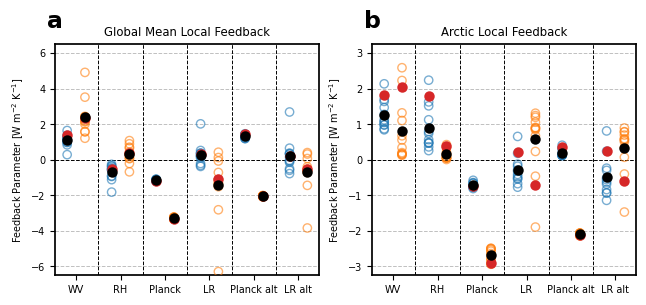

In [81]:
fig = plt.figure(figsize=(7.5,3))

ax = fig.add_subplot(121)

ax.text(-0.03, 1.05, 'a', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Global Mean Local Feedback')
#ax.set_xlim([-90,90])
ax.set_ylim([-6.5,6.5])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
       }

for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k',zorder=10)
    
ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver',zorder=10)

#ax.set_xticklabels([r'$\mathrm{{\lambda}_{WV}}',r'$\mathrm{\tilde{\lambda}_{RH}}',r'$\mathrm{{\lambda}_{P}}',r'$\mathrm{{\lambda}_{LR}}',r'$\mathrm{\tilde{\lambda}_{P}}',r'$\mathrm{\tilde{\lambda}_{LR}}'])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['WV','RH','Planck','LR','Planck alt','LR alt'])

for key in list(xlib.keys()):
    for month in np.arange(1,13,step=1):
        ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=month),facecolors='none', edgecolors='tab:blue',zorder=101,alpha=0.6)
        
for key in list(xlib.keys()):
    ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month'),facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101)

for key in list(xlib.keys()):
    ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(1,12)).mean('month'),facecolors='k', edgecolors='k',linewidth=1.5,zorder=101)

        
for key in list(xlib.keys()):
    for month in np.arange(1,13,step=1):
        ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=month),facecolors='none', edgecolors='tab:orange',zorder=101,alpha=0.6)
    
for key in list(xlib.keys()):
    ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(6,8)).mean('month'),facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101)

    
for key in list(xlib.keys()):
    ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'})).sel(month=slice(1,12)).mean('month'),facecolors='k', edgecolors='k',linewidth=1.5,zorder=101)

        
plt.axhline(0,linestyle='--',linewidth=0.7,c='k')

ax = fig.add_subplot(122)

ax.text(-0.03, 1.05, 'b', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Arctic Local Feedback')
#ax.set_xlim([-90,90])
ax.set_ylim([-3.25,3.25])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
    
for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k',zorder=10)

ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver',zorder=10)
    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
       }

#ax.set_xticklabels([r'$\mathrm{{\lambda}_{WV}}',r'$\mathrm{\tilde{\lambda}_{RH}}',r'$\mathrm{{\lambda}_{P}}',r'$\mathrm{{\lambda}_{LR}}',r'$\mathrm{\tilde{\lambda}_{P}}',r'$\mathrm{\tilde{\lambda}_{LR}}'])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['WV','RH','Planck','LR','Planck alt','LR alt'])

for key in list(xlib.keys()):
    for month in np.arange(1,13,step=1):
        ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=month)),facecolors='none', edgecolors='tab:blue',zorder=101,alpha=0.6)
        
for key in list(xlib.keys()):
    ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month'),facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101)

for key in list(xlib.keys()):
    ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month'),facecolors='k', edgecolors='k',linewidth=1.5,zorder=101)

        
for key in list(xlib.keys()):
    for month in np.arange(1,13,step=1):
        ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=month)),facecolors='none', edgecolors='tab:orange',zorder=101,alpha=0.6)
        
for key in list(xlib.keys()):
    ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month'),facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101)
for key in list(xlib.keys()):
    ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month'),facecolors='k', edgecolors='k', linewidth=1.5, zorder=101)

        
plt.axhline(0,linestyle='--',linewidth=0.7,c='k')
plt.savefig('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/moisture_tagging_paper/Figures/plots/moisture_tagging-supfigure_9-era5_feedbacks_local.png',dpi=600)

['JJA TOA', '$\\mathrm{\\lambda_{WV\\ LW}}$ Annual', 'Annual SFC', '$\\mathrm{\\lambda_{WV\\ LW}}$ JJA', 'Annual TOA', 'JJA SFC']


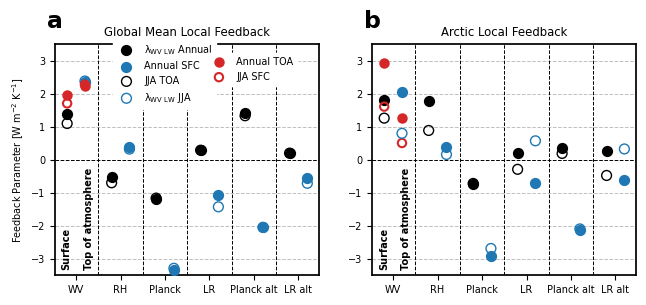

In [82]:
fig = plt.figure(figsize=(7.5,3))

ax = fig.add_subplot(121)

ax.text(-0.03, 1.05, 'a', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Global Mean Local Feedback')
#ax.set_xlim([-90,90])
#ax.set_ylim([-6.5,6.5])
ax.set_ylim([-3.5,3.5])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)

    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
        'dLW_logq':0,
        'dSW_logq':0,
       }

for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k')

ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver')

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['WV', 'RH', 'Planck', 'LR', 'Planck alt', 'LR alt'])

plt.axhline(0,linestyle='--',linewidth=0.7,c='k')

# Loop through the variables and plot the data
for key in xlib:
    ax.scatter(xpos[key] - 0.2, area_weighted_ave((surf_flux[key] / dTS).sel(latitude=slice(90,-90),month=slice(6,8)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='k',s=50,
               edgecolor='k',
               zorder=100,
               label='JJA SFC')
    ax.scatter(xpos[key] + 0.2, area_weighted_ave((toa_flux[key] / dTS).sel(latitude=slice(90,-90),month=slice(6,8)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='tab:blue',s=50,
               edgecolor='tab:blue',
               zorder=100,
               label='JJA TOA')
    ax.scatter(xpos[key] - 0.2, area_weighted_ave((surf_flux[key] / dTS).sel(latitude=slice(90,-90),month=slice(1,12)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='None',s=50,
               edgecolor='k',
               zorder=100,
               label='Annual SFC')
    ax.scatter(xpos[key] + 0.2, area_weighted_ave((toa_flux[key] / dTS).sel(latitude=slice(90,-90),month=slice(1,12)).rename({'latitude':'lat','longitude':'lon'})).mean('month'),
               c='None',s=50,
               edgecolor='tab:blue',
               zorder=100,
               label='Annual TOA')

key = 'dLW_logq'
sc1 = ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(6,8))).mean('month').values,
                 facecolors='tab:red', 
                 edgecolors='tab:red',
                 linewidth=1.5,
                 zorder=101,
                 c='tab:red',
                 label=r'$\mathrm{\lambda_{WV\ LW}}$ JJA')

key = 'dLW_logq'
sc2 = ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(1,12))).mean('month').values,
                 facecolors='None', 
                 edgecolors='tab:red',
                 linewidth=1.5,
                 zorder=101,
                 c='None',
                 label=r'$\mathrm{\lambda_{WV\ LW}}$ Annual')

key = 'dLW_logq'
ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(6,8))).mean('month').values,
           facecolors='tab:red', edgecolors='tab:red',
           linewidth=1.5,zorder=101)

key = 'dLW_logq'
scatter = ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(1,12))).mean('month').values,
                     c='None',facecolors='None', 
                     edgecolors='tab:red',
                     linewidth=1.5,zorder=101)
    
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles0 = handles[0:4]
unique_labels0 = [unique_labels[1],unique_labels[2],unique_labels[0],unique_labels[3]]
legend = ax.legend(handles0, unique_labels0, 
                   fontsize=7, loc='lower left', 
                   bbox_to_anchor=[0.2,0.7],
                   frameon=True, edgecolor='white', 
                   framealpha=1.0)

ax.add_artist(legend)  

handles1 = [handles[-2],handles[-1]]
print(unique_labels)
unique_labels1 = [unique_labels[-2],unique_labels[-1]]
legend2 = ax.legend(handles1, unique_labels1, 
                    bbox_to_anchor=[0.55,0.8],
                    fontsize=7, loc='lower left', 
                    frameon=True, edgecolor='white', 
                    framealpha=1.0)
ax.add_artist(legend2)

ax.text(0.025, 0.025, 'Surface', weight='bold',
        rotation='vertical',
        fontsize=7,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.text(0.11, 0.025, 'Top of atmosphere', weight='bold',
        rotation='vertical',
        fontsize=7,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)
        

#-------------------------------------------------------------
ax = fig.add_subplot(122)

ax.text(-0.03, 1.05, 'b', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Arctic Local Feedback')
#ax.set_xlim([-90,90])
ax.set_ylim([-3.5,3.5])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
#ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
    
for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k')

ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver')
    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
        'dLW_logq':0,
        'dSW_logq':0,
       }

ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['WV', 'RH', 'Planck', 'LR', 'Planck alt', 'LR alt'])

# Loop through the variables and plot the data
for key in xlib:
    ax.scatter(xpos[key] - 0.2, area_weighted_ave((surf_flux[key] / dTS).sel(latitude=slice(90,70),month=slice(6,8)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='k',s=50,
               edgecolor='k',
               zorder=100,
               label='JJA SFC')
    ax.scatter(xpos[key] + 0.2, area_weighted_ave((toa_flux[key] / dTS).sel(latitude=slice(90,70),month=slice(6,8)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='tab:blue',s=50,
               edgecolor='tab:blue',
               zorder=100,
               label='JJA TOA')
    ax.scatter(xpos[key] - 0.2, area_weighted_ave((surf_flux[key] / dTS).sel(latitude=slice(90,70),month=slice(1,12)).rename({'latitude':'lat','longitude':'lon'})).mean('month'), 
               c='None',s=50,
               edgecolor='k',
               zorder=100,
               label='Annual SFC')
    ax.scatter(xpos[key] + 0.2, area_weighted_ave((toa_flux[key] / dTS).sel(latitude=slice(90,70),month=slice(1,12)).rename({'latitude':'lat','longitude':'lon'})).mean('month'),
               c='None',s=50,
               edgecolor='tab:blue',
               zorder=100,
               label='Annual TOA')

key = 'dLW_logq'
sc1 = ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,
                 facecolors='tab:red', 
                 edgecolors='tab:red',
                 linewidth=1.5,
                 zorder=101,
                 c='tab:red',
                 label=r'$\mathrm{\lambda_{WV\ LW}}$ JJA')

key = 'dLW_logq'
sc2 = ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month').values,
                 facecolors='None', 
                 edgecolors='tab:red',
                 linewidth=1.5,
                 zorder=101,
                 c='None',
                 label=r'$\mathrm{\lambda_{WV\ LW}}$ Annual')

key = 'dLW_logq'
ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,
           facecolors='tab:red', edgecolors='tab:red',
           linewidth=1.5,zorder=101)

key = 'dLW_logq'
scatter = ax.scatter(xpos[key]+0.2,area_weighted_ave((toa_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month').values,
                     c='None',facecolors='None', 
                     edgecolors='tab:red',
                     linewidth=1.5,zorder=10)
"""   
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
handles0 = handles[0:4]
unique_labels0 = unique_labels[0:4]
legend = ax.legend(handles0, unique_labels0, 
                   fontsize=7, loc='lower left', 
                   bbox_to_anchor=[0.6,0.7],
                   frameon=True, edgecolor='white', 
                   framealpha=1.0)
ax.add_artist(legend)  

handles1 = [handles[-2],handles[-1]]
print(unique_labels)
unique_labels1 = [unique_labels[-2],unique_labels[-1]]
legend2 = ax.legend(handles1, unique_labels1, 
                    bbox_to_anchor=[0.2,0.8],
                    fontsize=7, loc='lower left', 
                    frameon=True, edgecolor='white', 
                    framealpha=1.0)
ax.add_artist(legend2)
"""
ax.text(0.025, 0.025, 'Surface', weight='bold',
        rotation='vertical',
        fontsize=7,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.text(0.11, 0.025, 'Top of atmosphere', weight='bold',
        rotation='vertical',
        fontsize=7,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

plt.axhline(0,linestyle='--',linewidth=0.7,c='k')
plt.savefig('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/moisture_tagging_paper/Figures/plots/moisture_tagging-supfigure_10-era5_feedbacks_local.png',dpi=600)

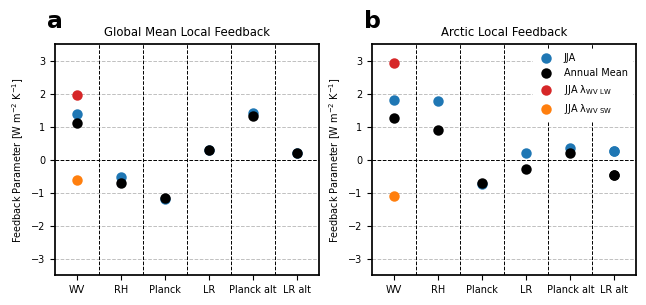

In [83]:
fig = plt.figure(figsize=(7.5,3))

ax = fig.add_subplot(121)

ax.text(-0.03, 1.05, 'a', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Global Mean Local Feedback')
ax.set_xlim([-0.5,5.5])
#ax.set_ylim([-6.5,6.5])
ax.set_ylim([-3.5,3.5])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
        'dLW_logq':0,
        'dSW_logq':0,
       }

for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k',zorder=10)
    
ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver',zorder=10)

#ax.set_xticklabels([r'$\mathrm{{\lambda}_{WV}}',r'$\mathrm{\tilde{\lambda}_{RH}}',r'$\mathrm{{\lambda}_{P}}',r'$\mathrm{{\lambda}_{LR}}',r'$\mathrm{\tilde{\lambda}_{P}}',r'$\mathrm{\tilde{\lambda}_{LR}}'])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['WV','RH','Planck','LR','Planck alt','LR alt'])

for key in list(xlib.keys()):
    ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(month=slice(6,8))).mean('month'),facecolors='tab:blue', edgecolors='tab:blue',linewidth=1.5,zorder=101)

for key in list(xlib.keys()):
    ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(month=slice(1,12))).mean('month'),facecolors='k', edgecolors='k',linewidth=1.5,zorder=101)

key = 'dLW_logq'
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(6,8))).mean('month').values,facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101,label=r'JJA $\mathrm{\lambda_{WV\ LW}}$')

key = 'dSW_logq'
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,-90),month=slice(6,8))).mean('month').values,facecolors='tab:orange', edgecolors='tab:orange',linewidth=1.5,zorder=101,label=r'JJA $\mathrm{\lambda_{WV\ SW}}$')
    
    
plt.axhline(0,linestyle='--',linewidth=0.7,c='k')

ax = fig.add_subplot(122)

ax.text(-0.03, 1.05, 'b', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

ax.set_title('Arctic Local Feedback')
ax.set_xlim([-0.5,5.5])
ax.set_ylim([-3.5,3.5])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel(r'Feedback Parameter [$\mathrm{W\ m^{-2}\ K^{-1}}$]')
#ax.set_xlabel('latitude')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
    
for i in range(5):
    ax.axvline(i+0.5,linestyle='--',linewidth=0.7,c='k')

ax.yaxis.grid(linestyle='--',linewidth=0.7,c='silver')
    
xlib = {'dLWSW_logq':r'$\mathrm{{\lambda}_{wv}}$',
        'dLW_rh':r'$\mathrm{\tilde{\lambda}_{rh}}$',
        'dLW_planck':r'$\mathrm{{\lambda}_{lr}}$',
        'dLW_lapse':r'$\mathrm{{\lambda}_{p}}$',
        'dLW_planck_alt':r'$\mathrm{\tilde{\lambda}_{p}}$',
        'dLW_lapse_alt':r'$\mathrm{\tilde{\lambda}_{lr}}$',
       }

xpos = {'dLWSW_logq':0,
        'dLW_rh':1,
        'dLW_planck':2,
        'dLW_lapse':3,
        'dLW_planck_alt':4,
        'dLW_lapse_alt':5,
        'dLW_logq':0,
        'dSW_logq':0,
       }

#ax.set_xticklabels([r'$\mathrm{{\lambda}_{WV}}',r'$\mathrm{\tilde{\lambda}_{RH}}',r'$\mathrm{{\lambda}_{P}}',r'$\mathrm{{\lambda}_{LR}}',r'$\mathrm{\tilde{\lambda}_{P}}',r'$\mathrm{\tilde{\lambda}_{LR}}'])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['WV','RH','Planck','LR','Planck alt','LR alt'])

#for key in list(xlib.keys()):
#    for month in np.arange(1,13,step=1):
#        ax.scatter(xpos[key]-0.2,area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=month)),facecolors='none', edgecolors='tab:blue',zorder=101,alpha=0.6)
        
for key in list(xlib.keys()):
    ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,facecolors='tab:blue', edgecolors='tab:blue',linewidth=1.5,zorder=101)

for key in list(xlib.keys()):
    ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month').values,facecolors='k', edgecolors='k',linewidth=1.5,zorder=101)

#-----------------------For legend
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,facecolors='tab:blue', edgecolors='tab:blue',linewidth=1.5,zorder=101,label='JJA')
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month').values,facecolors='k', edgecolors='k',linewidth=1.5,zorder=101,label='Annual Mean')

key = 'dLW_logq'
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,facecolors='tab:red', edgecolors='tab:red',linewidth=1.5,zorder=101,label=r'JJA $\mathrm{\lambda_{WV\ LW}}$')

key = 'dSW_logq'
ax.scatter(xpos[key],area_weighted_ave((surf_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month').values,facecolors='tab:orange', edgecolors='tab:orange',linewidth=1.5,zorder=101,label=r'JJA $\mathrm{\lambda_{WV\ SW}}$')
    
#for key in list(xlib.keys()):
#    ax.scatter(xpos[key]+0.2,area_weighted_ave((cam_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(6,8))).mean('month'),facecolors='None', edgecolors='tab:blue',linewidth=1.5,zorder=101,label='CAM5 SFC')
#for key in list(xlib.keys()):
#    ax.scatter(xpos[key]+0.2,area_weighted_ave((cam_flux[key]/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month'),facecolors='None', edgecolors='k', linewidth=1.5, zorder=101,label='CAM5 TOA')    

        
ax.legend(fontsize=7,loc='upper right',frameon=True,edgecolor='white',framealpha=1.0)
plt.axhline(0,linestyle='--',linewidth=0.7,c='k')
plt.savefig('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/moisture_tagging_paper/Figures/plots/moisture_tagging-supfigure_9-era5_feedbacks_local-surf.png',dpi=600)

In [84]:
fbs = area_weighted_ave((toa_flux/dTS).rename({'latitude':'lat','longitude':'lon'}).sel(lat=slice(90,70),month=slice(1,12))).mean('month')
fbs

<xarray.Dataset>
Dimensions:         ()
Coordinates:
    level           int32 1000
Data variables: (12/13)
    dLW_logq        float64 0.5074
    dSW_logq        float64 0.3215
    dLWSW_logq      float64 0.8017
    dLW_planck_alt  float64 -2.095
    dLW_lapse_alt   float64 0.3279
    dLW_qt          float64 0.3462
    ...              ...
    dLW_lapse       float64 0.5745
    dLW_planck      float64 -2.688
    dt_feedback     float64 -2.113
    dLW_ts          float64 -0.665
    dLW_ta          float64 -4.265
    t_feedback      float64 -4.93

In [85]:
def get_flux_region(dq,dqr=None,region=True):
    #  this custom function will compute vertical integrals
    #  taking advantage of xarray named coordinates
    def integral(field):
        return (field * dp_masked).sum(dim='pfull')
    
    #  actual specific humidity anomalies
    if region == True:
        DeltaQ = dq_new - dqr
    else:
        DeltaQ = dq_new
    #  relative humidity in control run (convert from percent to fraction)

    small = 0.01
    dqsatdT = (qsat(T_ctrl+small, T_ctrl.level) -
               qsat(T_ctrl-small, T_ctrl.level)) / (2*small)


    #  Equivalent temperature change
    #  (actual humidity change expressed as temperature change at fixed RH)
    #DeltaTequiv = DeltaQ / (RH_ctrl * dqsatdT )
    DeltaTequiv =  (DeltaQ/Q_ctrl*Rv.magnitude/Lv.magnitude*T_ctrl**2)
    #  Scaled by local surface temp. anomaly
    #DeltaTequiv_scaled = DeltaTequiv / DeltaTS
     #  But actually we are supposed to be using log(q)

    dlogqsatdT = (np.log(qsat(T_ctrl+small, T_ctrl.level)) -
               np.log(qsat(T_ctrl-small, T_ctrl.level))) / (2*small)

    DeltaLogQ = np.log(DeltaQ)
    dlogqsatdT = np.log(dqsatdT)

    DeltaTequiv_log = DeltaLogQ / (dlogqsatdT) 
    #  Interpolated to kernel grid:
    
    #  create a new dictionary to hold all the feedbacks
    flux = {}
    #   Compute the feedbacks!
    flux['lw_q'] = (k_q_lw2[f'{surf}_all'] * DeltaTequiv_log) # * dp / 100)
    #  shortwave water vapor
    flux['sw_q'] = (k_q_sw2[f'{surf}_all'] * DeltaTequiv_log) # * dp / 100)

    #  longwave temperature  (Planck and lapse rate)
    #flux['Planck'] =  (k_ts[f'{surf}_all'] +
    #                   (k_t2[f'{surf}_all'])) * dTREFHT #* dp / 100

    #flux['lapse'] = k_t2[f'{surf}_all'] * (dTA_new - dTREFHT) # * dp / 100
    #flux['lw_t'] = flux['Planck'] + flux['lapse']

    #  Add up the longwave feedbacks
    #flux['lw_net'] = flux['lw_t'] + flux['lw_q']

    flux['lw_q_trad'] = (k_q_lw2[f'{surf}_all'] * DeltaTequiv) # * dp / 100)
    flux['sw_q_trad'] = (k_q_sw2[f'{surf}_all'] * DeltaTequiv) # * dp / 100)
    
    flux['q_net'] = flux['lw_q'] + flux['sw_q']
    flux['q_net_trad'] = flux['lw_q_trad'] + flux['sw_q_trad']
    
    # temperature kernel for fixed relative humidity is the sum of
    #  traditional temperature and traditional water vapor kernels
    #lw_talt = k_t2[f'{surf}_all'] + k_q_lw2[f'{surf}_all']
    #flux['Planck_alt'] =  (k_ts[f'{surf}_all'] +
    #                       (lw_talt)) * dTREFHT #* dp / 100
    #flux['lapse_alt'] = (lw_talt *
    #                             (dTA_new-dTREFHT)) #* dp / 100
    # Get RH feedback by subtracting original water vapor kernel times
    # atmospheric temperature response from traditional water vapor feedback.
    flux['RH'] = flux['lw_q'] - (k_q_lw2[f'{surf}_all'] * dTA) # * dp / 100)

    #  package output into xarray datasets
    era5_flux = xr.Dataset(data_vars=flux)
    return era5_flux #/ dTREFHT.mean('longitude')

In [87]:
ntot = get_flux_region(dq_new,region=False)
ntot

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:     (level: 37, latitude: 73, longitude: 144, month: 12)
Coordinates:
  * level       (level) float32 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * latitude    (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude   (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lw_q        (month, level, latitude, longitude) float64 0.03841 ... nan
    sw_q        (month, level, latitude, longitude) float64 0.0 0.0 ... nan nan
    lw_q_trad   (month, level, latitude, longitude) float64 0.004871 ... 4.89...
    sw_q_trad   (month, level, latitude, longitude) float64 0.0 ... -1.223e-08
    q_net       (month, level, latitude, longitude) float64 0.03841 ... nan
    q_net_trad  (month, level, latitude, longitude) float64 0.004871 ... 3.66...
    RH          (month, level, latitude, longitude) float64 nan nan ... nan nan

In [88]:
test = [get_flux_region(dq,dqs.slope.sel(region=i).rename({'plev':'level'}),region=True) for i in dqs.region]
test = xr.concat(test,dim='region')
test

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/computation.py:760: RuntimeWa

KeyboardInterrupt: 

## Main Plot Start Here

In [89]:
surf = 'TOA'

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/thickness_normalized_ta_wv_kernel/'

dp = xr.open_dataset(dir+'dp_era5.nc')['dp']
dp.coords['month'] = np.arange(1,13,step=1)
k_t = xr.open_dataset(dir+f'ERA5_kernel_ta_dp_{surf}.nc')
k_t.coords['month'] = np.arange(1,13,step=1)
k_q_sw = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_dp_{surf}.nc')
k_q_sw.coords['month'] = np.arange(1,13,step=1)
k_q_lw = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_dp_{surf}.nc')
k_q_lw.coords['month'] = np.arange(1,13,step=1)
k_ts = xr.open_dataset(f'/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_{surf}.nc')
k_ts.coords['month'] = np.arange(1,13,step=1)

## Create new fixed relative humidity feedback
dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/layer_specified_ta_wv_kernel/'

k_t2 = xr.open_dataset(dir+f'ERA5_kernel_ta_nodp_{surf}.nc')
k_t2.coords['month'] = np.arange(1,13,step=1)
k_q_sw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_sw_nodp_{surf}.nc')
k_q_sw2.coords['month'] = np.arange(1,13,step=1)
k_q_lw2 = xr.open_dataset(dir+f'ERA5_kernel_wv_lw_nodp_{surf}.nc')
k_q_lw2.coords['month'] = np.arange(1,13,step=1)
k_ts

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 73, longitude: 144)
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    TOA_clr    (month, latitude, longitude) float64 ...
    TOA_all    (month, latitude, longitude) float64 ...

In [90]:
def r_create_flux(dq_in):
    flux = {}
    t1=T_ctrl
    dta=dTA_new
    q0 = Q_ctrl

    qs1 = qsat(t1,T_ctrl.level)
    qs2 = qsat(t1+dta,T_ctrl.level)
    dqsdt = (qs2 - qs1)/dta
    rh = 1000*q0/qs1
    dqdt = rh*dqsdt

    dlogqdt=dqdt/(1000*q0)


    # Normalize kernels by the change in moisture for 1 K warming at
    # constant RH (log-q kernel)
    logq_LW_kernel=(k_q_lw2[f'{surf}_clr']/dlogqdt)
    logq_SW_kernel=(k_q_sw2[f'{surf}_clr']/dlogqdt)

    dlogq=dq_in/q0

    # Convolve moisture kernel with change in moisture
    dLW_logq=(logq_LW_kernel*dlogq)
    dSW_logq=(logq_SW_kernel*dlogq)
    flux['dLW_logq']=integral(logq_LW_kernel*dlogq)
    flux['dSW_logq']=integral(logq_SW_kernel*dlogq)
    flux['dLWSW_logq'] = integral(dLW_logq + dSW_logq)
    
    lw_talt = k_t2[f'{surf}_all'] + k_q_lw2[f'{surf}_all']
    flux['dLW_planck_alt'] = (k_ts[f'{surf}_all'] +
                           integral(lw_talt)) * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_lapse_alt'] = integral(lw_talt * (dTA_new - dTREFHT))
    flux['dLW_qt'] = integral(k_q_lw2[f'{surf}_all'] * dTA_new)
    dLW_qt = (k_q_lw2[f'{surf}_all'] * dTA_new)
    flux['dLW_rh'] = integral(dLW_logq) - integral(dLW_qt)
    
    flux['dLW_lapse'] = integral(k_t2[f'{surf}_all'] * (dTA_new - dTREFHT))
    flux['dLW_planck'] = (k_ts[f'{surf}_all']+integral(k_t2[f'{surf}_all'])) * dTREFHT.sel(level=1000).squeeze()
    flux['dt_feedback'] = flux['dLW_lapse'] + flux['dLW_planck']
    
    flux['dLW_ts'] = k_ts[f'{surf}_all'] * dTREFHT.sel(level=1000).squeeze()
    flux['dLW_ta'] = integral(k_t[f'{surf}_all'] * dTA_new)
    flux['t_feedback'] = flux['dLW_ts'] + flux['dLW_ta']
    
    return xr.Dataset(flux)

In [91]:
def wv_feedback(dq_in):
    t1=T_ctrl
    dta=dTA_new
    q0 = Q_ctrl

    qs1 = qsat(t1,T_ctrl.level)
    qs2 = qsat(t1+dta,T_ctrl.level)
    dqsdt = (qs2 - qs1)/dta
    rh = 1000*q0/qs1
    dqdt = rh*dqsdt

    dlogqdt=dqdt/(1000*q0)


    # Normalize kernels by the change in moisture for 1 K warming at
    # constant RH (log-q kernel)
    logq_LW_kernel=(k_q_lw2[f'{surf}_clr']/dlogqdt)
    logq_SW_kernel=(k_q_sw2[f'{surf}_clr']/dlogqdt)

    dlogq=dq_in/q0

    # Convolve moisture kernel with change in moisture
    dLW_logq=(logq_LW_kernel*dlogq)
    dSW_logq=(logq_SW_kernel*dlogq)
    flux['dLW_logq']=integral(logq_LW_kernel*dlogq)
    flux['dSW_logq']=integral(logq_SW_kernel*dlogq)
    flux['dLWSW_logq'] = flux['dLW_logq'] + flux['dSW_logq']
    
    return dLW_logq + dSW_logq

In [92]:
## Create new fixed relative humidity feedback
k_ts = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/ERA5_kernels/ERA5_kernel_ts_TOA.nc')

dir = '/raid/scratch/scratch-itbaxter/exp/ERA5_radiative_kernels/Data_2024/other_kernels/kernel_cam5_res2.5_level37_toa_sfc.nc'

kernels = xr.open_dataset(dir)
kernels = kernels.rename({'time':'month'})
kernels.coords['month'] = np.arange(1,13,step=1)
kernels

<xarray.Dataset>
Dimensions:        (month: 12, latitude: 73, longitude: 144, level: 37)
Coordinates:
  * latitude       (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude      (longitude) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * level          (level) float32 1e+03 975.0 950.0 925.0 ... 5.0 3.0 2.0 1.0
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/20)
    ts_toa_clr     (month, latitude, longitude) float64 ...
    ts_toa_all     (month, latitude, longitude) float64 ...
    ts_sfc_clr     (month, latitude, longitude) float64 ...
    ts_sfc_all     (month, latitude, longitude) float64 ...
    ta_toa_clr     (month, level, latitude, longitude) float64 ...
    ta_toa_all     (month, level, latitude, longitude) float64 ...
    ...             ...
    wv_sw_sfc_clr  (month, level, latitude, longitude) float64 ...
    wv_sw_sfc_all  (month, level, latitude, longitude) float64 ...
    alb_toa_clr    (month, latitude, longitude) float64 ...
    alb_toa_all    (month, latitude, longitude) float64 ...
    alb_sfc_clr    (month, latitude, longitude) float64 ...
    alb_sfc_all    (month, latitude, longitude) float64 ...

In [93]:
def cam_wv_feedback(dq_in,surf='toa'):
    t1=T_ctrl
    dta=dTA_new
    q0 = Q_ctrl

    qs1 = qsat(t1,T_ctrl.level)
    qs2 = qsat(t1+dta,T_ctrl.level)
    dqsdt = (qs2 - qs1)/dta
    rh = 1000*q0/qs1
    dqdt = rh*dqsdt

    dlogqdt=dqdt/(1000*q0)


    # Normalize kernels by the change in moisture for 1 K warming at
    # constant RH (log-q kernel)
    logq_LW_kernel=(kernels[f'wv_lw_{surf}_all']/dlogqdt)
    logq_SW_kernel=(kernels[f'wv_sw_{surf}_all']/dlogqdt)

    dlogq=dq_in/q0

    # Convolve moisture kernel with change in moisture
    dLW_logq=(logq_LW_kernel*dlogq)
    dSW_logq=(logq_SW_kernel*dlogq)
    flux['dLW_logq']=integral(logq_LW_kernel*dlogq)
    flux['dSW_logq']=integral(logq_SW_kernel*dlogq)
    flux['dLWSW_logq'] = flux['dLW_logq'] + flux['dSW_logq']
    
    return dLW_logq + dSW_logq

In [94]:
areacella = xr.open_dataset('/raid/scratch/scratch-itbaxter/exp/CESM2-LE/CESM2.areacella.nc')['areacella'].squeeze().load()
#areacella.coords['lat'] = ti['lat']

rlist = np.arange(1,54,step=1)

latbounds = np.arange(-90,90.1,step=20)
lonbounds = np.arange(0,360.1,step=60)


arc_weighted = (areacella).sel(lat=slice(70,90)).sum(dim=['lat','lon'])

def weight_trends(arcealla,i):
    ds_w = np.zeros(6)
    for y in range(6):
        ds_w[y] = arcealla.sel(lat=slice(latbounds[i],latbounds[i+1]),lon=slice(lonbounds[y],lonbounds[y+1])).sum(dim=['lat','lon'])
    return ds_w
    
reg_weights = [weight_trends(areacella,i) for i in range(9)]
reg_weights = np.concatenate(reg_weights)

xreg_weights = xr.DataArray(np.std(reg_weights)/reg_weights,
                            dims=dqs.region.dims,
                            coords=dqs.region.coords)

#(reg_weights[i]/arc_weighted.values)
xreg_weights

<xarray.DataArray (region: 54)>
array([1.68690123, 1.68690123, 1.68690123, 1.68690123, 1.68690123,
       1.72204483, 0.60455883, 0.60455883, 0.60455883, 0.60455883,
       0.60455883, 0.61715378, 0.39677424, 0.39677424, 0.39677424,
       0.39677424, 0.39677424, 0.40504041, 0.32374695, 0.32374695,
       0.32374695, 0.32374695, 0.32374695, 0.3304917 , 0.29004923,
       0.29004923, 0.29004923, 0.29004923, 0.29004923, 0.29609195,
       0.32374698, 0.32374698, 0.32374698, 0.32374698, 0.32374698,
       0.33049172, 0.39677427, 0.39677427, 0.39677427, 0.39677427,
       0.39677427, 0.40504041, 0.60455883, 0.60455883, 0.60455883,
       0.60455883, 0.60455883, 0.61715382, 1.68690123, 1.68690123,
       1.68690123, 1.68690123, 1.68690123, 1.72204501])
Coordinates:
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 46 47 48 49 50 51 52 53 54

In [95]:
dqs_norm = dqs * xreg_weights
dqs_norm

<xarray.Dataset>
Dimensions:    (plev: 37, latitude: 73, longitude: 144, year: 42, month: 12,
                region: 54)
Coordinates:
  * plev       (plev) int32 1000 975 950 925 900 875 850 825 ... 20 10 7 5 3 2 1
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2019 2020 2021 2022
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) int64 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54
Data variables:
    slope      (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    intercept  (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    r          (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    p          (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    stderr     (region, month, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 37, 73, 144), meta=np.ndarray>
    predicted  (region, month, year, plev, latitude, longitude) float64 dask.array<chunksize=(1, 12, 42, 37, 73, 144), meta=np.ndarray>

In [96]:
idqs_norm = area_weighted_ave(integral((dqs_norm['slope']).sel(latitude=slice(90,70)).rename({'plev':'level'})).rename({'longitude':'lon','latitude':'lat'}))
idqs_norm

<xarray.DataArray (region: 54, month: 12)>
dask.array<truediv, shape=(54, 12), dtype=float64, chunksize=(1, 12), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 46 47 48 49 50 51 52 53 54

In [97]:
new_fb = [wv_feedback(dq_new-dqs.slope.sel(region=i).rename({'plev':'level'})) for i in dqs.region]
new_fb = xr.concat(new_fb,dim='region')
new_fb

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray (region: 54, month: 12, level: 37, latitude: 73,
                   longitude: 144)>
dask.array<concatenate, shape=(54, 12, 37, 73, 144), dtype=float64, chunksize=(1, 12, 37, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * level      (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) int64 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54

In [98]:
inew_fb = area_weighted_ave((new_fb/dTS).sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'}))
inew_fb

<xarray.DataArray (region: 54, month: 12, level: 37)>
dask.array<truediv, shape=(54, 12, 37), dtype=float64, chunksize=(1, 12, 37), chunktype=numpy.ndarray>
Coordinates:
  * level    (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 46 47 48 49 50 51 52 53 54

In [99]:
tot_fb = r_create_flux(dq_new)
itot_fb = area_weighted_ave((tot_fb/dTS).sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'}))
itot_fb

<xarray.Dataset>
Dimensions:         (month: 12)
Coordinates:
  * month           (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
    level           int32 1000
Data variables: (12/13)
    dLW_logq        (month) float64 0.2001 0.1173 0.06084 ... 0.141 0.1614
    dSW_logq        (month) float64 0.0007497 0.01404 0.1091 ... 0.002434 nan
    dLWSW_logq      (month) float64 0.2002 0.129 0.1699 ... 0.34 0.1424 0.1614
    dLW_planck_alt  (month) float64 -2.068 -2.063 -2.066 ... -2.075 -2.066
    dLW_lapse_alt   (month) float64 0.5717 0.5951 0.7905 ... 0.8951 0.6946
    dLW_qt          (month) float64 0.1544 0.1096 -0.01346 ... 0.081 0.1041
    ...              ...
    dLW_lapse       (month) float64 0.8495 0.9102 1.243 ... 1.195 1.31 1.058
    dLW_planck      (month) float64 -2.5 -2.488 -2.506 ... -2.681 -2.572 -2.534
    dt_feedback     (month) float64 -1.65 -1.578 -1.262 ... -1.485 -1.261 -1.476
    dLW_ts          (month) float64 -0.7654 -0.7602 -0.8149 ... -0.6425 -0.7425
    dLW_ta          (month) float64 -2.616 -2.503 -1.551 ... -2.823 -2.0 -2.315
    t_feedback      (month) float64 -3.381 -3.263 -2.366 ... -2.643 -3.057

In [100]:
new_test = [wv_feedback(dq_new-dqs.slope.sel(region=i).rename({'plev':'level'})) for i in dqs.region]
new_test = xr.concat(new_test,dim='region')
new_test

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray (region: 54, month: 12, level: 37, latitude: 73,
                   longitude: 144)>
dask.array<concatenate, shape=(54, 12, 37, 73, 144), dtype=float64, chunksize=(1, 12, 37, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * level      (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) int64 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54

In [101]:
surf = 'toa'
cam_test = [cam_wv_feedback(dq_new-dqs.slope.sel(region=i).rename({'plev':'level'})) for i in dqs.region]
cam_test = xr.concat(cam_test,dim='region')
cam_test

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray (region: 54, month: 12, level: 37, latitude: 73,
                   longitude: 144)>
dask.array<concatenate, shape=(54, 12, 37, 73, 144), dtype=float64, chunksize=(1, 12, 37, 73, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * level      (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region     (region) int64 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54

In [102]:
norm_test = new_test * xreg_weights

In [103]:
inorm_test = area_weighted_ave((integral(norm_test)/dTS).sel(latitude=slice(90,70)).rename({'latitude':'lat','longitude':'lon'}))
inorm_test

<xarray.DataArray (region: 54, month: 12)>
dask.array<truediv, shape=(54, 12), dtype=float64, chunksize=(1, 12), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 ... 46 47 48 49 50 51 52 53 54
    level    int32 1000

In [104]:
surf = 'TOA'
new_tot = wv_feedback(dq_new)
new_tot

<xarray.DataArray (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[ 6.57328327e-04,  6.61392559e-04,  6.65747140e-04, ...,
           6.43348364e-04,  6.48297492e-04,  6.52955006e-04],
         [ 7.34434406e-04,  7.51384196e-04,  7.60214319e-04, ...,
           6.66056089e-04,  6.85434947e-04,  7.08811128e-04],
         [ 5.66371113e-04,  5.80196001e-04,  5.90983612e-04, ...,
           5.26270315e-04,  5.29357495e-04,  5.51023955e-04],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[-6.00521751e-04, -6.01138912e-04, -6.01962168e-04, ...,
          -5.98689090e-04, -5.99539837e-04, -5.99982925e-04],
         [-5.23486378e-04, -5.20101753e-04, -5.14789492e-04, ...,
          -5.76604416e-04, -5.69595162e-04, -5.53908261e-04],
         [-8.07023849e-04, -8.54082658e-04, -8.89954783e-04, ...,
          -7.53315289e-04, -7.66280809e-04, -7.68482222e-04],
...
         [-5.51939851e-05, -5.53294202e-05, -5.56706715e-05, ...,
          -5.49378980e-05, -5.49951024e-05, -5.49659807e-05],
         [-5.90994340e-05, -5.89421235e-05, -5.90261322e-05, ...,
          -5.90328450e-05, -5.87335876e-05, -5.87987531e-05],
         [-5.92607344e-05, -5.92845790e-05, -5.93103749e-05, ...,
          -5.94318401e-05, -5.94624858e-05, -5.92429312e-05]],

        [[-3.04429138e-06, -3.04316848e-06, -3.04196199e-06, ...,
          -3.04632410e-06, -3.04543310e-06, -3.04498203e-06],
         [-3.26300198e-06, -3.26011571e-06, -3.26578829e-06, ...,
          -3.25801179e-06, -3.24824802e-06, -3.26504261e-06],
         [-3.42044237e-06, -3.40851932e-06, -3.41508094e-06, ...,
          -3.39741746e-06, -3.40193942e-06, -3.41262754e-06],
         ...,
         [-8.36597639e-05, -8.39391907e-05, -8.49007827e-05, ...,
          -8.31405519e-05, -8.32416502e-05, -8.34105494e-05],
         [-8.94156395e-05, -8.77399457e-05, -8.71753571e-05, ...,
          -8.86205174e-05, -8.65203351e-05, -8.77784083e-05],
         [-8.72068170e-05, -8.72626087e-05, -8.73193198e-05, ...,
          -8.78028333e-05, -8.78442437e-05, -8.71441713e-05]]]])
Coordinates:
  * level      (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [105]:
surf = 'toa'

cam_tot = cam_wv_feedback(dq_new)
cam_tot

<xarray.DataArray (month: 12, level: 37, latitude: 73, longitude: 144)>
array([[[[-0.00153546, -0.00153833, -0.00155337, ..., -0.00151367,
          -0.00152217, -0.0015325 ],
         [-0.00050524, -0.0004494 , -0.00037993, ..., -0.00046769,
          -0.00050458, -0.00051876],
         [ 0.00090467,  0.00111485,  0.00126221, ...,  0.00036874,
           0.0005201 ,  0.00067625],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[-0.011095  , -0.01110876, -0.01112834, ..., -0.01108426,
          -0.01109041, -0.01109837],
         [-0.01107311, -0.01101337, -0.01097017, ..., -0.01109376,
          -0.0111123 , -0.01112866],
         [-0.01170456, -0.01197939, -0.01225576, ..., -0.01062581,
          -0.01110649, -0.01146866],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]])
Coordinates:
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * level      (level) float32 1e+03 975.0 950.0 925.0 900.0 ... 5.0 3.0 2.0 1.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [106]:
# Number of boxes
num_boxes  = 54
xnum_boxes = 6
ynum_boxes = 9

box = ((280,310),(60,75))

# Define latitude and longitude bounds
lat_min, lat_max = -90.0, 90.0
lon_min, lon_max = -180.0, 180.0

# Generate equally spaced latitude and longitude values
latitudes = np.linspace(lat_min, lat_max, ynum_boxes)
longitudes = np.linspace(lon_min, lon_max, xnum_boxes)

# Create a meshgrid of latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Assign unique integer values to each grid cell
grid_values = np.arange(1, num_boxes + 1).reshape(lat_grid.shape)
print(grid_values.shape,lat_grid.shape)

# Create an xarray dataset with the grid and values
#grid = xr.Dataset(
#    {'grid_values': (['lat', 'lon'], grid_values)},
#    coords={'lat': (['lat'], latitudes[:-1]), 'lon': (['lon'], longitudes[:-1])},
#)

#itest = area_weighted_ave(((ntot['q_net_trad']-test['q_net_trad'])/ dTREFHT.mean('longitude').sel(level=1000)).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))
#itest_new = area_weighted_ave(integral((ntot['q_net_trad']-test['q_net_trad'])/ dTREFHT.mean('longitude').sel(level=1000)).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))

itest = area_weighted_ave((((new_tot-new_test))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))
itest_new = area_weighted_ave(((integral(new_tot-new_test))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))

grid = xr.DataArray(itest_new.values.reshape(lat_grid.shape),
                    name=r'Contribution to Arctic WV feedback',
                    dims=('lat','lon'),
                    coords={'lat': latitudes[:], 'lon': longitudes[:]},
                   )

# Display the resulting xarray dataset
print(grid)

(9, 6) (9, 6)
<xarray.DataArray 'Contribution to Arctic WV feedback' (lat: 9, lon: 6)>
array([[-2.94089404e-05, -2.94185998e-05, -2.93314469e-05,
        -2.83043109e-05, -2.90754515e-05, -2.95166615e-05],
       [ 3.07203063e-05,  3.23252176e-05, -2.12563845e-05,
         1.55391565e-05,  6.84839557e-05,  2.49790030e-06],
       [ 1.41178660e-03,  2.04885241e-03, -3.29715915e-04,
        -4.01907815e-05,  1.61399898e-03,  4.75395257e-04],
       [ 2.30892449e-02,  1.11270745e-02, -8.33492926e-03,
         9.50792728e-04,  1.70879000e-02,  8.99527998e-03],
       [ 2.56731354e-02,  3.61129760e-03, -2.88515121e-03,
         1.76310310e-02,  1.76305814e-02,  2.37704424e-02],
       [ 3.59804126e-03,  7.98459871e-02,  1.20741744e-01,
         7.12961193e-02,  1.80789310e-01,  7.62546280e-02],
       [ 3.11503596e-02,  4.34361203e-03,  3.08089752e-02,
         9.56742285e-04,  5.86629898e-02,  3.41843050e-02],
       [ 2.48061074e-01,  3.53644948e-01,  1.14715633e-01,
         7.35984515e-

/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/itbaxter/.conda/envs/ianpy37/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [107]:
itest_norm = area_weighted_ave(((integral(new_tot-new_test))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))


In [108]:
inew_tot = area_weighted_ave(((integral(new_tot))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))

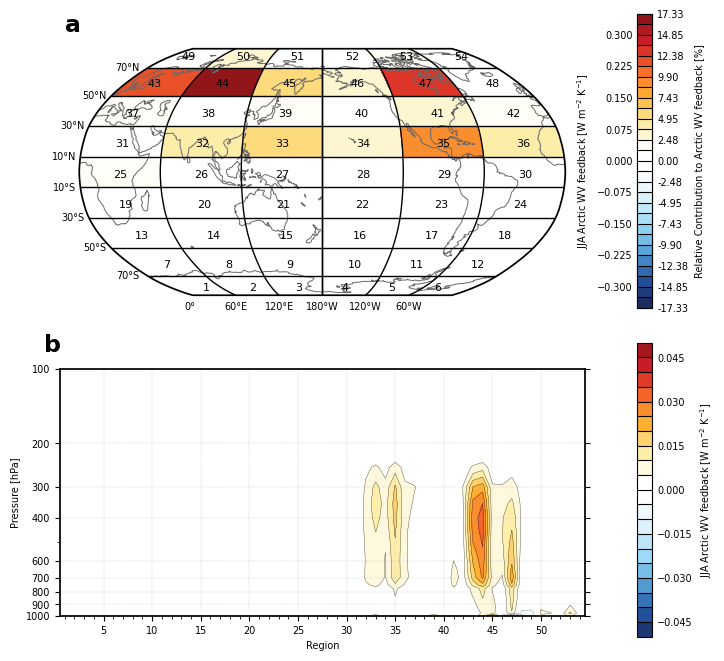

In [109]:

# Create a custom RdYlBu colormap with white in the middle
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['hatch.color'] = 'silver'

fig = plt.figure(figsize=(7.5,7))
# Panel 1--------------------------------------------------
ax = fig.add_subplot(211,projection=ccrs.Robinson(central_longitude=180))
#ax = fig.add_axes([0,0.35,0.5,0.35],ccrs.NorthPolarStereo())
#ax.set_extent([-180,180,-90,90],ccrs.PlateCarree())
ax.coastlines(linewidth=0.7,alpha=1.0,color='dimgray')

#ax.text(-0.4, 0.25, 'iCESM1', weight='bold',
#        fontsize=17,
#        rotation=0,
#        horizontalalignment='left',
#         verticalalignment='bottom', transform=ax.transAxes)

ax.text(-0.03, 1.05, 'a', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

num_rows = 9
num_cols = 6

# Generate evenly spaced squares in a grid
cnt = 1
for i in range(num_rows):
    for j in range(num_cols):
        lon1 = 0 + j * (360 / num_cols)
        lat1 = -90 + i * (180 / num_rows)
        lon2 = lon1 + (360 / num_cols)
        lat2 = lat1 + (180 / num_rows)

        square = {'name': f'{cnt}', 'coords': (lon1, lat1, lon2, lat2)}

        # Plot the squares
        rectangle = Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, edgecolor='None', facecolor='none')
        ax.add_patch(rectangle)
        if abs(grid.values[i,j]) >= 1:
            ax.text(lon1+25, lat2-15, square['name'], color='white', fontsize=8, va='bottom', ha='left', transform=ccrs.PlateCarree())
        else:
            ax.text(lon1+25, lat2-15, square['name'], color='black', fontsize=8, va='bottom', ha='left', transform=ccrs.PlateCarree())
        cnt += 1

# Create a grid of values corresponding to the squares
x = np.linspace(0, 360, num_cols + 1)
y = np.linspace(-90, 90, num_rows + 1)
X, Y = np.meshgrid(x, y)
Z = np.random.rand(num_rows, num_cols)  # Replace this with your actual data

# Plot the pcolormesh grid with the specified colormap and normalization
#norm = BoundaryNorm(boundaries, new_cmap.N, clip=True)

cmap = colormaps.BlueWhiteOrangeRed
#levels = np.arange(-0.06,0.061,step=0.005)
#levels = np.arange(-0.04,0.041,step=0.005)
levels = np.arange(-0.35,0.351,step=0.025)
#levels = np.linspace(-abs(np.max(grid)),abs(np.max(grid)),20)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#new_cmap = LinearSegmentedColormap('RdYlBu_r', cmap['levels'])
#contour = ax.pcolormesh(X, Y, 1000*r_diff_values, cmap=new_cmap, shading='auto', 
#                        transform=ccrs.PlateCarree(), alpha=1.0,norm=norm)
p = ax.pcolormesh(X, Y, grid.values, 
                        cmap=cmap,
                        #shading='auto', 
                        alpha=1.0, 
                        norm=norm,
                        transform=ccrs.PlateCarree(),
                       )
# Colorbar

cax = fig.add_axes([0.85,0.55,0.02,0.42])
cb = plt.colorbar(p,orientation='vertical', 
                  cax=cax,
                  drawedges=True,
                  #ticks=levels[::2]
                 )
#cb.set_ticklabels(f'{levels:0.02f}') #[::3])
cb.set_label(r'JJA Arctic WV feedback [W $\mathrm{m^{-2}\ K^{-1}}$] ')
cb.outline.set_color('k')
cb.outline.set_linewidth(0.8)
cb.dividers.set_color('k')
cb.dividers.set_linewidth(0.8)
cb.ax.tick_params(size=0)
cb.ax.minorticks_off()
cb.ax.yaxis.set_label_position('left')

cb.ax.set_aspect('auto')
pos = cb.ax.get_position()

# create a second axes instance and set the limits you need
cax2 = cb.ax.twinx()
#cax2.set_ylim([-1,1])

# resize the colorbar (otherwise it overlays the plot)
#pos.x0 +=0.05
cax2.set_position(pos)

fmt = lambda x, pos: '{:.02f}'.format(x)

cb2 = plt.colorbar(p,cax2,orientation='vertical',
                  drawedges=True,
                  ticks=levels[::2],
                 )
ticklabels = 100*(levels[::2]/np.sum(grid.values))
cb2.ax.set_yticklabels(["{:.02f}".format(i) for i in ticklabels])
#cb2.ax.set_yticklabels(ticklabels)
cb2.outline.set_color('k')
cb2.outline.set_linewidth(0.8)
cb2.dividers.set_color('k')
cb2.dividers.set_linewidth(0.8)
cb2.ax.tick_params(size=0)
cb2.ax.minorticks_off()
cb2.set_label(r'Relative Contribution to Arctic WV feedback [%]')
cb2.ax.yaxis.set_label_position('right')

ax.spines['geo'].set_linewidth(1.25)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1.0,  
                  x_inline=False,
                  y_inline=False,
                  rotate_labels=False, color='k', 
                  linestyle='-', alpha=1.0)
gl.top_labels = False  # Turn off top labels
gl.left_labels = True  # Turn off left labels
gl.right_labels = False  # Turn off left labels
gl.ylabels = False
gl.xlabel_style={'color':'k'}

# Customize the gridline labels if needed
gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -70, -50, -30, -10, 10, 30, 50, 70, 90])

#####################################################
## Panel b-------------------------------------------
#####################################################

ax = fig.add_subplot(212)
ax.set_xlim([0.5,54.5])
#if surf == 'TOA':
ax.set_ylim([100,1000])
#else:
#    ax.set_ylim([600,1000])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Region')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
ax.invert_yaxis()
ax.set_yscale("log")
ax.yaxis.set_major_locator(FixedLocator([100,200,300,400,600,700,800,900,1000])) #AutoLocator())
ax.yaxis.set_major_formatter('{x:3.0f}')
#ax.set_xticks(np.arange(-10, 91, 20), [r'-10°S', r'10°N', r'30°N', r'50°N', r'70°N', r'90°N']) #  r'90°N', r'60°N', r'30°N', 
ax.tick_params(right=True)
ax.xaxis.set_major_locator(MultipleLocator(5)) #AutoLocator())
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.grid(linestyle='--',alpha=0.7,linewidth=0.35,
        color='silver')

ax.text(-0.03, 1.05, 'b', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

cmap = colormaps.BlueWhiteOrangeRed
#bounds = np.arange(-0.016,0.0161,0.002)
#bounds = np.arange(-0.08,0.081,0.01)
bounds = np.arange(-0.05,0.051,step=0.005)
#bounds = np.arange(-0.0036,0.00361,step=0.0004)
#bounds = np.linspace(-abs(np.max(itest)),abs(np.max(itest)),20)
#rtmqs,lons = add_cyclic_point(rtmq.slope,rtmq['lon'])
p = ax.contourf(np.arange(1,55,step=1),itest['level'].values,np.array(itest),
                cmap=cmap,
                #extend='both',
                levels=bounds,
                )

ln1 = ax.contour(np.arange(1,55,step=1),itest['level'].values,np.array(itest),
               levels=np.concatenate([bounds[:10],bounds[11:]]),
                linewidths=0.2,
               colors='k',
              )
"""
ln2 = ax.contour(np.arange(1,55,step=1),ti['lev'].values,np.array(aregional_feedback).T,
               levels=[0],
               linewidths=1.0,
               colors='k',
              )

clab2 = ax.clabel(ln2, ln2.levels, inline=True, fmt=fmt, fontsize=7)
for l in clab2:
    l.set_rotation(0)
"""
cax = fig.add_axes([0.85,0.08,0.02,0.42])
cb = plt.colorbar(p,orientation='vertical', 
                  cax=cax,
                  drawedges=True,
                  #ticks=bounds[::2]
                 )
#cb.set_ticklabels(f'{levels:0.02f}') #[::3])
cb.set_label(r'JJA Arctic WV feedback [W $\mathrm{m^{-2}\ K^{-1}}$] ')
cb.outline.set_color('k')
cb.outline.set_linewidth(0.8)
cb.dividers.set_color('k')
cb.dividers.set_linewidth(0.8)
cb.ax.tick_params(size=0)
cb.ax.minorticks_off()


#fig.subplots_adjust(top=0.92,bottom=0.07,left=0.1,right=1.0,hspace=0.3,wspace=0.1)
fig.subplots_adjust(top=0.92,bottom=0.11,left=0.08,right=0.78,hspace=0.3,wspace=0.1)
plt.savefig('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/moisture_tagging_paper/Figures/plots/moisture_tagging-figure_4-era5.blue2-toa.png',dpi=600)

In [110]:
# Number of boxes
num_boxes  = 54
xnum_boxes = 6
ynum_boxes = 9

box = ((280,310),(60,75))

# Define latitude and longitude bounds
lat_min, lat_max = -90.0, 90.0
lon_min, lon_max = -180.0, 180.0

# Generate equally spaced latitude and longitude values
latitudes = np.linspace(lat_min, lat_max, ynum_boxes)
longitudes = np.linspace(lon_min, lon_max, xnum_boxes)

# Create a meshgrid of latitudes and longitudes
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Assign unique integer values to each grid cell
grid_values = np.arange(1, num_boxes + 1).reshape(lat_grid.shape)
print(grid_values.shape,lat_grid.shape)

# Create an xarray dataset with the grid and values
#grid = xr.Dataset(
#    {'grid_values': (['lat', 'lon'], grid_values)},
#    coords={'lat': (['lat'], latitudes[:-1]), 'lon': (['lon'], longitudes[:-1])},
#)

#itest = area_weighted_ave(((ntot['q_net_trad']-test['q_net_trad'])/ dTREFHT.mean('longitude').sel(level=1000)).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))
#itest_new = area_weighted_ave(integral((ntot['q_net_trad']-test['q_net_trad'])/ dTREFHT.mean('longitude').sel(level=1000)).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))

itest = area_weighted_ave((((cam_tot-cam_test))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))
itest_new = area_weighted_ave(((integral(cam_tot-cam_test))/dTS).sel(month=slice(6,8),latitude=slice(90,70)).mean('month').rename({'latitude':'lat','longitude':'lon'}))

grid = xr.DataArray(itest_new.values.reshape(lat_grid.shape),
                    name=r'Contribution to Arctic WV feedback',
                    dims=('lat','lon'),
                    coords={'lat': latitudes[:], 'lon': longitudes[:]},
                   )

# Display the resulting xarray dataset
print(grid)

(9, 6) (9, 6)
<xarray.DataArray 'Contribution to Arctic WV feedback' (lat: 9, lon: 6)>
array([[-5.79970724e-05, -5.80255429e-05, -5.78187501e-05,
        -5.55005513e-05, -5.72438177e-05, -5.82397486e-05],
       [ 7.06717727e-05,  7.92251786e-05, -4.10010793e-05,
         4.02797655e-05,  1.54959765e-04,  1.21728093e-05],
       [ 3.10596206e-03,  4.43999545e-03, -7.21565421e-04,
        -9.40296461e-05,  3.52697998e-03,  1.07298339e-03],
       [ 5.05032437e-02,  2.41934217e-02, -1.84606776e-02,
         1.91600822e-03,  3.73482523e-02,  1.96516846e-02],
       [ 5.75876791e-02,  9.22329105e-03, -6.39295247e-03,
         3.91357863e-02,  3.87595090e-02,  5.33330190e-02],
       [ 8.82506461e-03,  1.85998496e-01,  2.74234893e-01,
         1.58158850e-01,  4.10594952e-01,  1.80156709e-01],
       [ 5.98502905e-02,  2.52257304e-03,  6.69234074e-02,
        -1.71856140e-02,  1.64053503e-01,  6.40451124e-02],
       [ 5.32162613e-01,  7.95203830e-01,  2.94418289e-01,
         1.52503746e-

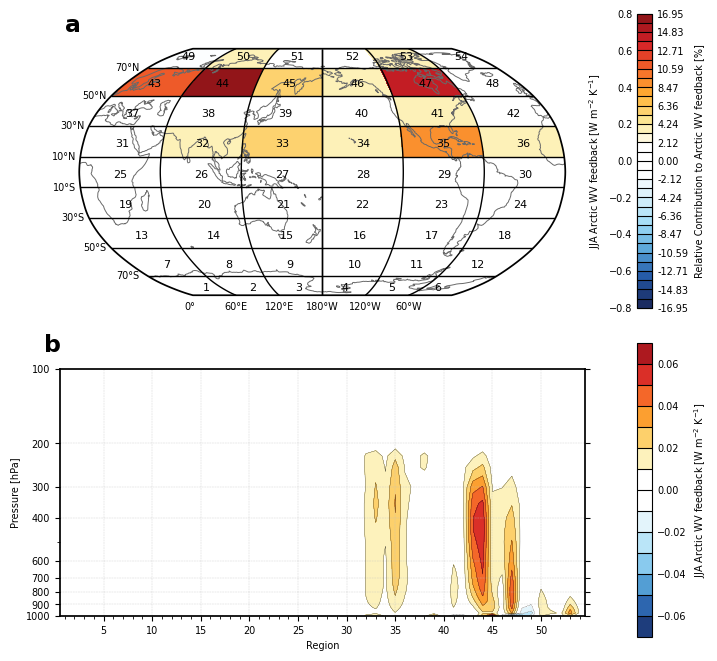

In [111]:
surf = 'TOA'

# Create a custom RdYlBu colormap with white in the middle
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 7
mpl.rcParams['hatch.color'] = 'silver'

fig = plt.figure(figsize=(7.5,7))
# Panel 1--------------------------------------------------
ax = fig.add_subplot(211,projection=ccrs.Robinson(central_longitude=180))
#ax = fig.add_axes([0,0.35,0.5,0.35],ccrs.NorthPolarStereo())
#ax.set_extent([-180,180,-90,90],ccrs.PlateCarree())
ax.coastlines(linewidth=0.7,alpha=1.0,color='dimgray')

#ax.text(-0.4, 0.25, 'iCESM1', weight='bold',
#        fontsize=17,
#        rotation=0,
#        horizontalalignment='left',
#         verticalalignment='bottom', transform=ax.transAxes)

ax.text(-0.03, 1.05, 'a', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

num_rows = 9
num_cols = 6

# Generate evenly spaced squares in a grid
cnt = 1
for i in range(num_rows):
    for j in range(num_cols):
        lon1 = 0 + j * (360 / num_cols)
        lat1 = -90 + i * (180 / num_rows)
        lon2 = lon1 + (360 / num_cols)
        lat2 = lat1 + (180 / num_rows)

        square = {'name': f'{cnt}', 'coords': (lon1, lat1, lon2, lat2)}

        # Plot the squares
        rectangle = Rectangle((lon1, lat1), lon2 - lon1, lat2 - lat1, edgecolor='None', facecolor='none')
        ax.add_patch(rectangle)
        if abs(grid.values[i,j]) >= 1:
            ax.text(lon1+25, lat2-15, square['name'], color='white', fontsize=8, va='bottom', ha='left', transform=ccrs.PlateCarree())
        else:
            ax.text(lon1+25, lat2-15, square['name'], color='black', fontsize=8, va='bottom', ha='left', transform=ccrs.PlateCarree())
        cnt += 1

# Create a grid of values corresponding to the squares
x = np.linspace(0, 360, num_cols + 1)
y = np.linspace(-90, 90, num_rows + 1)
X, Y = np.meshgrid(x, y)
Z = np.random.rand(num_rows, num_cols)  # Replace this with your actual data

# Plot the pcolormesh grid with the specified colormap and normalization
#norm = BoundaryNorm(boundaries, new_cmap.N, clip=True)

cmap = colormaps.BlueWhiteOrangeRed
#levels = np.arange(-0.06,0.061,step=0.005)
#levels = np.arange(-0.04,0.041,step=0.005)
levels = np.arange(-0.8,0.81,step=0.05)
#levels = np.linspace(-abs(np.max(grid)),abs(np.max(grid)),20)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

#new_cmap = LinearSegmentedColormap('RdYlBu_r', cmap['levels'])
#contour = ax.pcolormesh(X, Y, 1000*r_diff_values, cmap=new_cmap, shading='auto', 
#                        transform=ccrs.PlateCarree(), alpha=1.0,norm=norm)
p = ax.pcolormesh(X, Y, grid.values, 
                        cmap=cmap,
                        #shading='auto', 
                        alpha=1.0, 
                        norm=norm,
                        transform=ccrs.PlateCarree(),
                       )
# Colorbar

cax = fig.add_axes([0.85,0.55,0.02,0.42])
cb = plt.colorbar(p,orientation='vertical', 
                  cax=cax,
                  drawedges=True,
                  #ticks=levels[::2]
                 )
#cb.set_ticklabels(f'{levels:0.02f}') #[::3])
cb.set_label(r'JJA Arctic WV feedback [W $\mathrm{m^{-2}\ K^{-1}}$] ')
cb.outline.set_color('k')
cb.outline.set_linewidth(0.8)
cb.dividers.set_color('k')
cb.dividers.set_linewidth(0.8)
cb.ax.tick_params(size=0)
cb.ax.minorticks_off()
cb.ax.yaxis.set_label_position('left')

cb.ax.set_aspect('auto')
pos = cb.ax.get_position()

# create a second axes instance and set the limits you need
cax2 = cb.ax.twinx()
#cax2.set_ylim([-1,1])

# resize the colorbar (otherwise it overlays the plot)
#pos.x0 +=0.05
cax2.set_position(pos)

fmt = lambda x, pos: '{:.02f}'.format(x)

cb2 = plt.colorbar(p,cax2,orientation='vertical',
                  drawedges=True,
                  ticks=levels[::2],
                 )
ticklabels = 100*(levels[::2]/np.sum(grid.values))
cb2.ax.set_yticklabels(["{:.02f}".format(i) for i in ticklabels])
#cb2.ax.set_yticklabels(ticklabels)
cb2.outline.set_color('k')
cb2.outline.set_linewidth(0.8)
cb2.dividers.set_color('k')
cb2.dividers.set_linewidth(0.8)
cb2.ax.tick_params(size=0)
cb2.ax.minorticks_off()
cb2.set_label(r'Relative Contribution to Arctic WV feedback [%]')
cb2.ax.yaxis.set_label_position('right')

ax.spines['geo'].set_linewidth(1.25)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1.0,  
                  x_inline=False,
                  y_inline=False,
                  rotate_labels=False, color='k', 
                  linestyle='-', alpha=1.0)
gl.top_labels = False  # Turn off top labels
gl.left_labels = True  # Turn off left labels
gl.right_labels = False  # Turn off left labels
gl.ylabels = False
gl.xlabel_style={'color':'k'}

# Customize the gridline labels if needed
gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -70, -50, -30, -10, 10, 30, 50, 70, 90])

#####################################################
## Panel b-------------------------------------------
#####################################################

ax = fig.add_subplot(212)
ax.set_xlim([0.5,54.5])
if surf == 'TOA':
    ax.set_ylim([100,1000])
else:
    ax.set_ylim([600,1000])
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Region')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.25)
ax.invert_yaxis()
ax.set_yscale("log")
ax.yaxis.set_major_locator(FixedLocator([100,200,300,400,600,700,800,900,1000])) #AutoLocator())
ax.yaxis.set_major_formatter('{x:3.0f}')
#ax.set_xticks(np.arange(-10, 91, 20), [r'-10°S', r'10°N', r'30°N', r'50°N', r'70°N', r'90°N']) #  r'90°N', r'60°N', r'30°N', 
ax.tick_params(right=True)
ax.xaxis.set_major_locator(MultipleLocator(5)) #AutoLocator())
ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.grid(linestyle='--',alpha=0.7,linewidth=0.35,
        color='silver')

ax.text(-0.03, 1.05, 'b', weight='bold',
        fontsize=17,
        horizontalalignment='left',
        verticalalignment='bottom', transform=ax.transAxes)

cmap = colormaps.BlueWhiteOrangeRed
#bounds = np.arange(-0.016,0.0161,0.002)
#bounds = np.arange(-0.08,0.081,0.01)
bounds = np.arange(-0.07,0.071,step=0.01)
#bounds = np.arange(-0.0036,0.00361,step=0.0004)
#bounds = np.linspace(-abs(np.max(itest)),abs(np.max(itest)),20)
#rtmqs,lons = add_cyclic_point(rtmq.slope,rtmq['lon'])
p = ax.contourf(np.arange(1,55,step=1),itest['level'].values,np.array(itest),
                cmap=cmap,
                #extend='both',
                levels=bounds,
                )

ln1 = ax.contour(np.arange(1,55,step=1),itest['level'].values,np.array(itest),
               levels=np.concatenate([bounds[:7],bounds[8:]]),
                linewidths=0.2,
               colors='k',
              )
"""
ln2 = ax.contour(np.arange(1,55,step=1),ti['lev'].values,np.array(aregional_feedback).T,
               levels=[0],
               linewidths=1.0,
               colors='k',
              )

clab2 = ax.clabel(ln2, ln2.levels, inline=True, fmt=fmt, fontsize=7)
for l in clab2:
    l.set_rotation(0)
"""
cax = fig.add_axes([0.85,0.08,0.02,0.42])
cb = plt.colorbar(p,orientation='vertical', 
                  cax=cax,
                  drawedges=True,
                  #ticks=bounds[::2]
                 )
#cb.set_ticklabels(f'{levels:0.02f}') #[::3])
cb.set_label(r'JJA Arctic WV feedback [W $\mathrm{m^{-2}\ K^{-1}}$] ')
cb.outline.set_color('k')
cb.outline.set_linewidth(0.8)
cb.dividers.set_color('k')
cb.dividers.set_linewidth(0.8)
cb.ax.tick_params(size=0)
cb.ax.minorticks_off()


#fig.subplots_adjust(top=0.92,bottom=0.07,left=0.1,right=1.0,hspace=0.3,wspace=0.1)
fig.subplots_adjust(top=0.92,bottom=0.11,left=0.08,right=0.78,hspace=0.3,wspace=0.1)
plt.savefig('/raid/scratch/scratch-itbaxter/exp/amip-low-water-nudging3/moisture_tagging_paper/Figures/plots/moisture_tagging-figure_4-era5.blue2_toa-cam5.png',dpi=600)